#### MSC Geomet - Highlighting an error with the Accessing flow predictions data from Geomet

In [7]:
# data
import warnings
import re
import time
import configparser
from datetime import datetime, timedelta
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

# web map services 
from owslib.wms import WebMapService
from owslib.wcs import WebCoverageService
from owslib.wcs import Authentication

from GeneralProcessing.gen_streamflow_file import GenStreamflowFile

In [8]:
config = configparser.ConfigParser()
config.read_file(open('../config.cfg'))

login = config['Login']
username = config['Login']['Username']
password = config['Login']['Password']

In [9]:
# filter warnings or be prepared to see plenty
warnings.filterwarnings('ignore', module='owslib', category=UserWarning)

In [12]:
# use username and password parameters individually
# wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS&LAYERS={layer_name}',
# create WMS object
layer_name = 'DHPS_1km_RiverDischarge'
wms = WebMapService(
    f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS&LAYERS={layer_name}',
    version='1.3.0',
    auth=Authentication(username=username, password=password),
    timeout=300
)

layer_metadata = wms[layer_name]
print(layer_metadata.dimensions)
oldest_fcast, latest_fcast, issue_interval  = layer_metadata.dimensions['reference_time']['values'][0].split('/')
first_time, last_time, time_interval = layer_metadata.dimensions['time']['values'][0].split('/')
# layer_metadata.dimensions['reference_time']['values'][-1].split('/')

iso_format = "%Y-%m-%dT%H:%M:%SZ"

# convert date strings to datetime objects
first = datetime.strptime(first_time, iso_format)
first = first - timedelta(hours=13)
print(f"first : {first}")
last = datetime.strptime(last_time, iso_format)
print(f"last : {last}")


# remove anything that isn't a number from the datetime interval (time between forecasts)
intvl = int(re.sub(r'\D', '', time_interval))
print(f"intvl : {intvl}")


# create a list of forecast datetimes
hrs = [first]
a = 14
while first < last:
    first = first + timedelta(hours=intvl)
    hrs.append(first)
print(f"hrs: {hrs}")

# create a list of ISO formatted forecast datetime strings
fcasthrs = [datetime.strftime(hr, iso_format) for hr in hrs]
print(f"fcsthrs:{fcasthrs}")

# # layer details
# for key, value in vars(wms[layer_name]).items():
#     if value: # not all layers have values for the full set of available details
#         print(key) # let's just print the details applicable to this layer

{'time': {'units': 'ISO8601', 'default': '2025-07-09T20:00:00Z', 'nearestValue': '0', 'values': ['2025-07-09T13:00:00Z/2025-07-15T12:00:00Z/PT1H']}, 'reference_time': {'units': 'ISO8601', 'default': '2025-07-09T12:00:00Z', 'multipleValues': '1', 'nearestValue': '0', 'values': ['2025-07-07T00:00:00Z/2025-07-09T12:00:00Z/PT12H']}}
first : 2025-07-09 00:00:00
last : 2025-07-15 12:00:00
intvl : 1
hrs: [datetime.datetime(2025, 7, 9, 0, 0), datetime.datetime(2025, 7, 9, 1, 0), datetime.datetime(2025, 7, 9, 2, 0), datetime.datetime(2025, 7, 9, 3, 0), datetime.datetime(2025, 7, 9, 4, 0), datetime.datetime(2025, 7, 9, 5, 0), datetime.datetime(2025, 7, 9, 6, 0), datetime.datetime(2025, 7, 9, 7, 0), datetime.datetime(2025, 7, 9, 8, 0), datetime.datetime(2025, 7, 9, 9, 0), datetime.datetime(2025, 7, 9, 10, 0), datetime.datetime(2025, 7, 9, 11, 0), datetime.datetime(2025, 7, 9, 12, 0), datetime.datetime(2025, 7, 9, 13, 0), datetime.datetime(2025, 7, 9, 14, 0), datetime.datetime(2025, 7, 9, 15, 0), 

In [26]:
wcs = WebCoverageService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WCS&COVERAGEID={layer_name}',
                    version='2.0.1',
                    auth=Authentication(username=login['Username'], password=login['Password']),
                    timeout=300)

# layer details
for key, value in vars(wcs[layer_name]).items():
    if value is not None: # not all layers have values for the full set of available details
        print(key) # let's just print the details applicable to this layer

_elem
_service
id
keywords


In [27]:
# let's have a look at some of the details
print(wms[layer_name].title)
print(wms[layer_name].boundingBoxWGS84)

EHPS - Minimum of streamflow discharge for ensemble and previous 3 hours [m³/s]
(-149.74167, 38.991633, -52.499984, 70.999971)


In [28]:
# time metadata is stored in the dimensions attribute
wms[layer_name].dimensions['reference_time']['values']

['2025-06-08T00:00:00Z/2025-06-10T00:00:00Z/P1D']

In [ ]:
# formatting the reference time information
oldest_fcast, newest_fcast, issue_interval = wms[layer_name].dimensions['reference_time']['values'][0].split('/')
print('The first forecast issue is available at: ' + oldest_fcast)
print('The last forecast issue is available at: ' + newest_fcast)
print('The hourly interval between issued forecasts is: ' + issue_interval)

In [23]:
# layer_name = 'HRDPA-Prelim_2.5km_Precip-Accum6h'
# layer_name = 'HRDPA-Prelim_2.5km_Precip-Accum24h-T06Z'
# layer_name = 'HRDPA-Prelim_2.5km_Precip-Accum24h-T12Z'
# layer_name = 'HRDPA_2.5km_Precip-Accum6h'
# layer_name = 'HRDPA_2.5km_Precip-Accum24h-T06Z'
# layer_name = 'HRDPA_2.5km_Precip-Accum24h-T12Z'
# layer_name = 'EHPS_1km_RiverDischarge-Min3h'
# layer_name = 'ALERTS'
wcs = WebCoverageService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WCS&COVERAGEID={layer_name}',
                         auth=Authentication(username=login['Username'], password=login['Password']),
                         version='2.0.1',
                         timeout=300
                         )

zone_extraction = []
lat_bounds = [43.0, 53.5]
lon_bounds = [-81.5, -57.0]
zone_extraction = [('lat', lat_bounds[0], lat_bounds[1]), ('lon', lon_bounds[0], lon_bounds[1])]

response = wcs.getCoverage(
        identifier=[layer_name], 
        format='image/netcdf', 
        subsettingcrs='EPSG:4326', 
        subsets=zone_extraction,
        DIM_REFERENCE_TIME=ref_time, # capitalization here is important
        TIME=time # capitalization here is important
    )    
# read into an xarray
ds = xr.open_dataset(response.read()).load()
# add time metadata as a new dimension and coordinate
ds = ds.expand_dims(
    time=[datetime.strptime(time, "%Y-%m-%dT%H:%M:%SZ")]
)

NameError: name 'lat' is not defined

In [19]:
# layer details
for key, value in vars(wms[layer_name]).items():
    if value:  # not all layers have values for the full set of available details
        print(key)  # print the attribute name
        print(getattr(wms[layer_name], key))  # dynamically access the value of the attribute using getattr


auth
<Authentication shared=False username=None password=None cert=None verify=True auth_delegate=None>
parent
Layer Name: DHPS Title: DHPS
index
1.1.1.1
id
DHPS_1km_RiverDischarge
name
DHPS_1km_RiverDischarge
queryable
1
title
DHPS - Streamflow discharge [m³/s]
abstract
The Deterministic Hydrological Prediction System (DHPS) is the one-dimensional, river discharge routing component of the National Surface and River Prediction System (NSRPS). It provides both analyses and forecasts, routing water through a river basin’s lakes and rivers at a 1-km grid resolution using the WATROUTE model. Currently, the river networks of approximately 50% of Canada are represented. Twice a day, launching at 00 and 12 UTC, DHPS performs a 12-h data assimilation cycle followed by a 6-day forecast. The data assimilation cycle is piloted by fluxes of water provided by NSRPS-CaLDAS, while the forecast is piloted by fluxes of water from NSRPS-HRDLPS. These fluxes consist of accumulated hourly surface runoff a

In [8]:
# let's have a look at some of the details
print(wms[layer_name].title)
# print(wms[layer_name].dimensions)

# time metadata is stored in the dimensions attribute
print(wms[layer_name].boundingBox)
# print(wms[layer_name].defaulttimeposition)
# print(wms[layer_name].dimensions['time']['values'][0])

RDPA - Quantity of precipitation over a 6h hour interval [mm] [10 km] (archive)
(-180.0, -3.85657, 180.0, 90.0, 'EPSG:102978')


In [9]:
from pyproj import CRS, Transformer

# Example proj string for EPSG:102998 (check its actual definition)
source_crs = CRS.from_proj4("+proj=longlat +datum=WGS84 +no_defs")  # Replace with actual proj string
dest_crs = CRS.from_epsg(4326)  # Destination: WGS84 (EPSG:4326)

# Continue as before with transformation
transformer = Transformer.from_crs(source_crs, dest_crs, always_xy=True)


# Original bounding box: (min_x, min_y, max_x, max_y)
bounding_box = (-133.7, 27.3, -40.7, 66.6)

# Convert corners of bounding box from EPSG:102998 to EPSG:4326
min_lon, min_lat = transformer.transform(bounding_box[0], bounding_box[1])
max_lon, max_lat = transformer.transform(bounding_box[2], bounding_box[3])

print(f"Reprojected Bounding Box: ({min_lon}, {min_lat}, {max_lon}, {max_lat})")



Reprojected Bounding Box: (-133.7, 27.3, -40.7, 66.6)


In [21]:
# formatting the reference time information
first, last, interval = wms[layer_name].dimensions['reference_time']['values'][0].split('/')

print('The first forecast issue is available at: ' + first)
print('The last forecast issue is available at: ' + last)
print('The forecast intervals are every: ' + interval)
print(type(first))

The first forecast issue is available at: 2025-06-08T00:00:00Z
The last forecast issue is available at: 2025-06-10T12:00:00Z
The forecast intervals are every: PT12H
<class 'str'>


In [11]:
# let's print the operations available from the wms and the product formatting options
for op in wms.operations:
    print(op.name, op.formatOptions)

GetCapabilities ['text/xml']
GetMap ['image/png', 'image/jpeg']
GetFeatureInfo ['text/plain', 'application/json', 'application/vnd.ogc.gml']
DescribeLayer ['text/xml']
GetLegendGraphic ['image/png', 'image/jpeg', 'image/png; mode=8bit', 'image/vnd.jpeg-png', 'image/vnd.jpeg-png8']
GetStyles ['text/xml']


In [12]:
wcs = WebCoverageService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WCS&COVERAGEID={layer_name}',
                         auth=Authentication(username=login['Username'], password=login['Password']),
                         version='2.0.1',
                         timeout=300
                         )

# layer details
# for key, value in vars(wcs[layer_name]).items():
#     if value is not None: # not all layers have values for the full set of available details
#         print(key) # let's just print the details applicable to this layer

In [13]:
# response = wcs.getCoverage(identifier=[layer_name],
#                            # format='image/png',
#                            # subsettingcrs='EPSG:4326',  # Default and recommended crs
#                         #   subsets = [('lat', -10, 50), ('lon', -75, 75)],
#                         #    TIME='2025-01-05T00:00:00Z' # capitalization here is important
#                            )

response = wcs.getCoverage(
    identifier=[layer_name], 
    format='image/netcdf', 
    outputcrs='EPSG:102998',
    subsettingcrs='EPSG:102998', 
    subsets=[('lat', 27.3, 66.6), ('lon', -133.7, -40.7)],
    interpolation='nearest',
    # TIME='2023-07-05T12:00:00Z'
)

print(dir(response))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_response', 'geturl', 'info', 'read']


In [14]:
'https://geo.weather.gc.ca/geomet?version=1.3.0&service=WMS&request=GetLegendGraphic&sld_version=1.1.0&layer=ALERTS&format=image/png&STYLE=ALERTS'
'https://geo.weather.gc.ca/geomet?version=2.0.1&request=GetCoverage&service=WCS&CoverageID=ALERTS&format=image%2Fpng'
# note the lack of time info
print(response.info())
print(response.geturl())
print(response.info()['Content-Disposition'])

{'Date': 'Mon, 03 Mar 2025 20:55:07 GMT', 'Server': 'Apache', 'Strict-Transport-Security': 'max-age=63072000; preload', 'Content-Disposition': 'attachment; filename="geomet-weather_RDPA_10km_Precip-Accum6h_2025-03-03T1200Z.nc"', 'Access-Control-Allow-Origin': '*', 'Access-Control-Allow-Headers': 'Origin, X-Requested-With, Content-Type, Accept, Authorization', 'Access-Control-Allow-Methods': 'POST, GET, OPTIONS', 'Content-Type': 'image/netcdf', 'Keep-Alive': 'timeout=5, max=100', 'Connection': 'Keep-Alive', 'Transfer-Encoding': 'chunked'}
https://geo.weather.gc.ca/geomet?version=2.0.1&request=GetCoverage&service=WCS&CoverageID=RDPA_10km_Precip-Accum6h&format=image%2Fnetcdf&outputcrs=EPSG%3A102998&subsettingcrs=EPSG%3A102998&interpolation=nearest&subset=lat%2827.3%2C66.6%29&subset=lon%28-133.7%2C-40.7%29
attachment; filename="geomet-weather_RDPA_10km_Precip-Accum6h_2025-03-03T1200Z.nc"


<xarray.Dataset>
Dimensions:  (lat: 403, lon: 286)
Coordinates:
  * lat      (lat) float64 27.35 27.45 27.54 27.64 ... 66.26 66.36 66.45 66.55
  * lon      (lon) float64 -133.5 -133.2 -132.9 -132.6 ... -41.51 -41.19 -40.86
Data variables:
    Band1    (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    GDAL_TIFFTAG_RESOLUTIONUNIT:  2
    GDAL_TIFFTAG_XRESOLUTION:     72.0
    GDAL_TIFFTAG_YRESOLUTION:     72.0
    Conventions:                  CF-1.5
    GDAL:                         GDAL 3.5.2, released 2022/09/02
    history:                      Mon Mar 03 20:55:07 2025: GDAL CreateCopy( ...


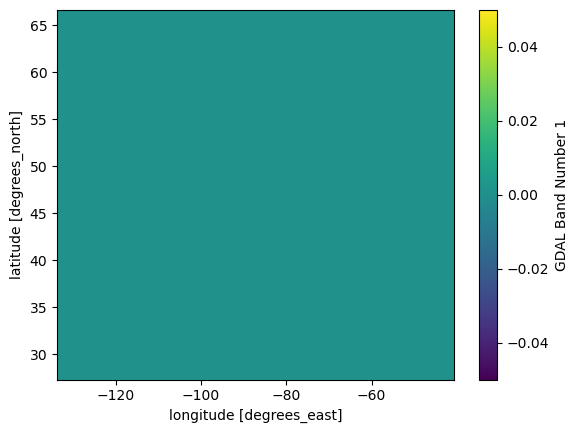

In [19]:
# read into an xarray
ds = xr.open_dataset(response.read(), engine='scipy').load()
# print the header for the DataArray
print(ds)
ds['Band1'].plot()
# dss = ds.expand_dims(time=[first])
# dss['Band1'].plot()

In [20]:
def plot_dataset(dataset : xr.Dataset):
    # First we specify Coordinate Refference System for Map Projection
    # We will use Mercator, which is a cylindrical, conformal projection. 
    # It has bery large distortion at high latitudes, cannot 
    # fully reach the polar regions.
    projection = ccrs.Mercator()
    # Specify CRS, that will be used to tell the code, where should our data be plotted
    crs = ccrs.PlateCarree()
    # Now we will create axes object having specific projection 
    plt.figure(figsize=(16,9), dpi=150)
    ax = plt.axes(projection=projection, frameon=True)
    # Draw gridlines in degrees over Mercator map
    gl = ax.gridlines(crs=crs, draw_labels=True,
                    linewidth=.6, color='gray', alpha=0.5, linestyle='-.')
    gl.xlabel_style = {"size" : 7}
    gl.ylabel_style = {"size" : 7}
    # To plot borders and coastlines, we can use cartopy feature
    import cartopy.feature as cf
    ax.add_feature(cf.COASTLINE.with_scale("50m"), lw=0.5)
    ax.add_feature(cf.BORDERS.with_scale("50m"), lw=0.3)

    # Now, we will specify extent of our map in minimum/maximum longitude/latitude
    # Note that these values are specified in degrees of longitude and degrees of latitude
    # However, we can specify them in any crs that we want, but we need to provide appropriate
    # crs argument in ax.set_extent
    lon_min = -133.7
    lon_max = -40.7
    lat_min = 27.3
    lat_max = 66.6

    ##### WE ADDED THESE LINES #####
    cbar_kwargs = {'orientation':'vertical', 'shrink':0.6, "pad" : .05, 'aspect':40}
    dataset["Band1"].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, vmax=50, levels=8)
    ################################

    # crs is PlateCarree -> we are explicitly telling axes, that we are creating bounds that are in degrees
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
    plt.title("Preciptation")
    plt.show()

    # hvplot can be used to show an interactive map of the xarray (tip: hover your cursor over the plot)
    # ds.sel(time='2024-09-05 13:00:00').hvplot(width=800, height=700, cmap='viridis', cnorm='linear')

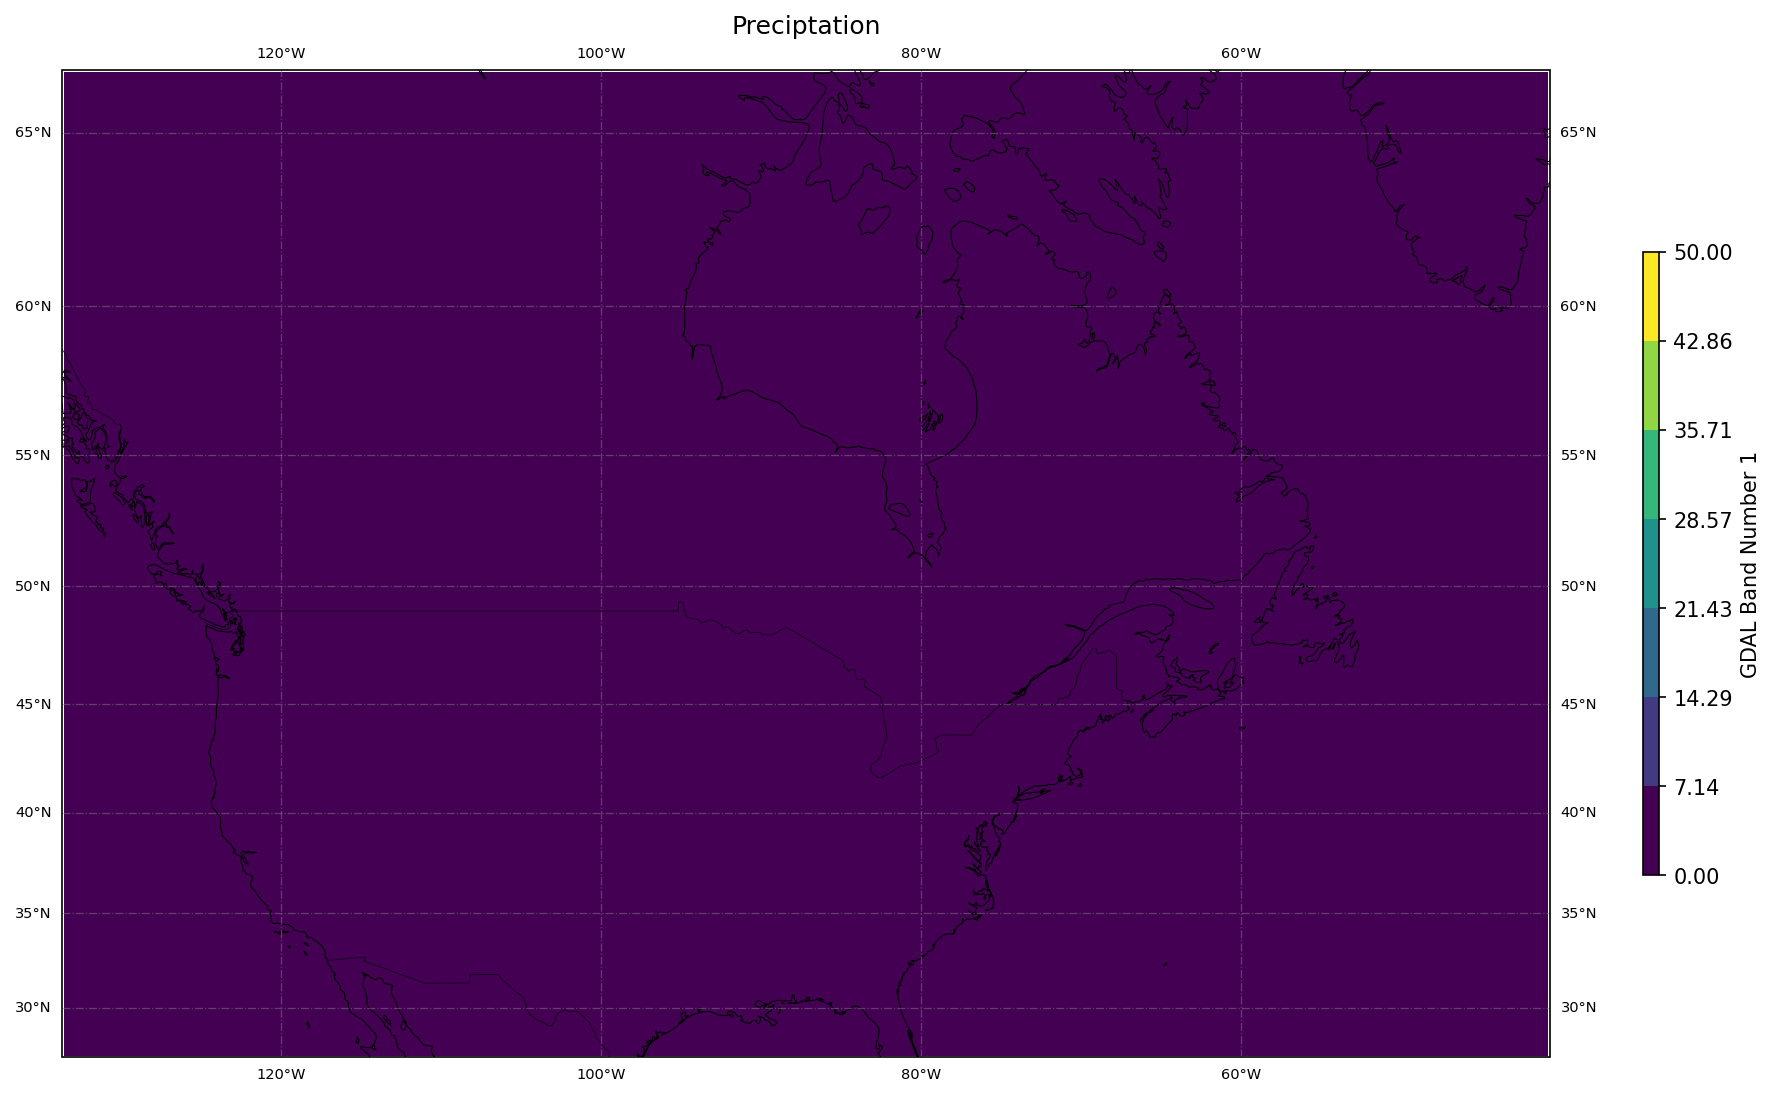

In [21]:
plot_dataset(dataset=ds)

In [456]:
# convert the datetime string to a datetime object
# iso_format = "%Y-%m-%dT%H:%M:%SZ"
# oldestf = datetime.strptime(first, iso_format)
# oldestf

datetime.datetime(2025, 1, 11, 12, 0)

In [457]:
# # remove the non-numerical characters from the datetime interval and convert to an integer
# intvl = int(re.sub(r'\D', '', interval))
# intvl

24

In [274]:
# # find the datetime object for the first available forecast hour
# firsthr = oldestf + timedelta(hours=intvl)
# # convert back to a string for the request
# first_fcasthr = datetime.strftime(firsthr, iso_format)
# first_fcasthr # first available time from the most recent forecast

'2025-01-11T06:00:00Z'

In [275]:
# wcs = WebCoverageService(
#     f'https://geo.weather.gc.ca/geomet?&SERVICE=WCS&COVERAGEID={layer_name}', 
#     auth=Authentication(username=login['Username'], password=login['Password']),
#     version='2.0.1',
#     timeout=300
# )

# response = wcs.getCoverage(
#     identifier=[layer_name], 
#     format='image/netcdf', 
#     outputcrs='EPSG:102998',
#     subsettingcrs='EPSG:102998', 
#     subsets=zone_extraction,
#     interpolation='nearest'
# )
    
# # read into an xarray
# ds = xr.open_dataset(response.read(), engine='scipy').load()

# # select data layer for plotting later
# da = ds['Band1']

In [282]:
# da.sum()

<xarray.DataArray 'Band1' ()>
array(0., dtype=float32)

In [217]:
# layer_name = 'High Resolution Deterministic Precipitation Analysis (HRDPA) [2.5 km]'
# # layer_name = 'Regional Deterministic Precipitation Analysis (RDPA) [10 km]'

# # use username and password parameters individually
# # wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS&LAYERS={layer_name}',
# wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS',
#                     version='1.3.0',
#                     username=login['Username'],
#                     password=login['Password'],
#                     timeout=300)

# # let's check what data are available for the Water Cycle Prediction System (WCPS)
# for key in list(wms.contents.keys()):
#     if "Precipitation" in key:
#         print(key)





In [214]:
# layer_name = 'HRDPA_2.5km_Precip-Accum24h-T12Z'
# wcs = WebCoverageService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WCS&COVERAGEID={layer_name}',
#                          auth=Authentication(username=login['Username'], password=login['Password']),
#                          version='2.0.1',
#                          timeout=300
#                          )

In [215]:
# # layer details
# for key, value in vars(wcs[layer_name]).items():
#     if value is not None:  # not all layers have values for the full set of available details
#         print(key)  # print the attribute name
#         # print(getattr(wms[layer_name], key))  # dynamically access the value of the attribute using getattr


In [216]:
# # let's have a look at some of the details
# print(wms[layer_name].title)
# print(wms[layer_name].dimensions)

In [198]:
# # Assuming 'wms[layer_name]._children' contains a list of ContentMetadata objects
# children = getattr(wms[layer_name], "_children", [])

# # Iterate over each ContentMetadata object in the list
# for child in children:
#     print(f"ContentMetadata Object: {child}")

#     # Use vars() or dir() to inspect the attributes of each ContentMetadata object
#     for key, value in vars(child).items():
#         if value is not None:  # Only print attributes with values
#             print(f"  {key}: {value}")


In [219]:
# # time metadata is stored in the dimensions attribute
# wms[layer_name].boundingBox

In [220]:
# from pyproj import CRS, Transformer

# # Example proj string for EPSG:102998 (check its actual definition)
# source_crs = CRS.from_proj4("+proj=longlat +datum=WGS84 +no_defs")  # Replace with actual proj string
# dest_crs = CRS.from_epsg(4326)  # Destination: WGS84 (EPSG:4326)

# # Continue as before with transformation
# transformer = Transformer.from_crs(source_crs, dest_crs, always_xy=True)


# # Original bounding box: (min_x, min_y, max_x, max_y)
# bounding_box = (-133.7, 27.3, -40.7, 66.6)

# # Convert corners of bounding box from EPSG:102998 to EPSG:4326
# min_lon, min_lat = transformer.transform(bounding_box[0], bounding_box[1])
# max_lon, max_lat = transformer.transform(bounding_box[2], bounding_box[3])

# print(f"Reprojected Bounding Box: ({min_lon}, {min_lat}, {max_lon}, {max_lat})")



In [237]:
# # formatting the reference time information
# # first= wms[layer_name].dimensions['time']['values'][0]
# # last= wms[layer_name].dimensions['time']['values'][-1]
# first, last, interval = wms[layer_name].dimensions['time']['values'][0].split('/')

# print('The first forecast issue is available at: ' + first)
# print('The last forecast issue is available at: ' + last)
# print('The forecast intervals are every: ' + interval)

In [238]:
# # looking at the default reference time
# wms[layer_name].dimensions['time']['default']

In [239]:
# wms[layer_name].dimensions['time']['values']

In [240]:
# # formatting the time information
# first, last, interval = wms[layer_name].dimensions['time']['values'][0].split('/')
# print('The first datetime available is: ' + first)
# print('The last datetime available is: ' + last)
# print('The hourly interval between available times is: ' + interval)

In [241]:
# # let's print the operations available from the wms and the product formatting options
# for op in wms.operations:
#     print(op.name, op.formatOptions)


In [247]:
# zone_extraction = [('lat', min_lat, max_lat), ('lon', min_lon, max_lon)]


# wcs = WebCoverageService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WCS&COVERAGEID={layer_name}',
#                          auth=Authentication(username=login['Username'], password=login['Password']),
#                          version='2.0.1',
#                          timeout=300
#                          )

# # layer details
# for key, value in vars(wcs[layer_name]).items():
#     if value is not None: # not all layers have values for the full set of available details
#         print(key) # let's just print the details applicable to this layer




In [13]:
# print the "abstract" for the GeoMet WCS
# print(wcs.identification.abstract)

In [14]:
# # some additional wcs metadata
# print("URL: " + wcs.url)
# print("Version: " + wcs.version)
# print("Provider: " + wcs.provider.name)
# print("Provider URL: " + wcs.provider.url)

In [15]:
# # let's print the operations available from the wms and the product formatting options
# for op in wcs.operations:
#     print(op.name, op.formatOptions)

In [248]:
# response = wcs.getCoverage(identifier=[layer_name],
#                            format='image/netcdf',
#                            subsettingcrs='EPSG:102998',  # Default and recommended crs
#                            subsets = [('lat', min_lat, max_lat), ('lon', min_lon, max_lon)],)
# print(dir(response))
# # exception_report = response.read()
# # print(exception_report.decode())  # Decode the bytes to a human-readable string


In [249]:
# # note the lack of time info
# print(response.info())
# print(response.geturl())
# print(response.info()['Content-Disposition'])

In [250]:
# # read into an xarray
# ds = xr.open_dataset(response.read(), engine='scipy').load()
# # print the header for the DataArray
# ds.head(5)

In [18]:
# # note the lack of time info
# response.geturl()
# response.info()['Content-Disposition']

In [19]:
# first

In [20]:
# interval

In [98]:
# convert the datetime string to a datetime object
iso_format = "%Y-%m-%dT%H:%M:%SZ"
oldestf = datetime.strptime(first, iso_format)
oldestf
llla = datetime.strptime(last, iso_format)
llla

datetime.datetime(2025, 2, 10, 12, 0)

In [99]:
# remove the non-numerical characters from the datetime interval and convert to an integer
intvl = int(re.sub(r'\D', '', interval))
intvl

24

In [183]:
# # find the datetime object for the first available forecast hour
# firsthr = oldestf + timedelta(hours=intvl)
# # convert back to a string for the request
# first_fcasthr = datetime.strftime(firsthr, iso_format)
# first_fcasthr # first available time from the most recent forecast
# fff = datetime.strftime(oldestf, iso_format)
# fff
# lll = datetime.strftime(llla, iso_format)
# lll
# firsthr

datetime.datetime(2025, 1, 11, 12, 0)

In [187]:
# # redo the response with the DIM_REFERENCE_TIME and TIME arguments
# response = wcs.getCoverage(identifier = [layer_name], 
#                     format = 'image/netcdf', 
#                     subsettingcrs = 'EPSG:4326', 
#                     subsets = [('lat', 48.0, 52.0), ('lon', -98.0, -92.0)], 
#                     DIM_REFERENCE_TIME=first, # capitalization here is important
#                     TIME=fff # capitalization here is important
#                    )

# response.info()['Content-Disposition']

wcs = WebCoverageService(
    f'https://geo.weather.gc.ca/geomet?&SERVICE=WCS&COVERAGEID={layer_name}', 
    auth=Authentication(username=login['Username'], password=login['Password']),
    version='2.0.1',
    timeout=300
)

response = wcs.getCoverage(
    identifier=[layer_name], 
    format='image/netcdf', 
    outputcrs='EPSG:102998',
    subsettingcrs='EPSG:102998', 
    subsets=zone_extraction,
    interpolation='nearest'
)
    
# read into an xarray
ds = xr.open_dataset(response.read(), engine='scipy').load()

# select data layer for plotting later
da = ds['Band1']

In [193]:
# # read into an xarray
# ds = xr.open_dataset(response.read()).load()
# print(da)
# add the time metadata as a new dimension and coordinate
dss = ds.expand_dims(time=[last])
# print the header for the DataArray, note the new time information
dss.head

<bound method Dataset.head of <xarray.Dataset>
Dimensions:  (time: 1, lat: 1288, lon: 2538)
Coordinates:
  * time     (time) object '2025-02-10T12:00:00Z'
  * lat      (lat) float64 27.32 27.35 27.38 27.41 ... 66.49 66.52 66.55 66.58
  * lon      (lon) float64 -133.7 -133.6 -133.6 -133.6 ... -40.79 -40.75 -40.72
Data variables:
    Band1    (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    GDAL_TIFFTAG_RESOLUTIONUNIT:  2
    GDAL_TIFFTAG_XRESOLUTION:     72.0
    GDAL_TIFFTAG_YRESOLUTION:     72.0
    Conventions:                  CF-1.5
    GDAL:                         GDAL 3.5.2, released 2022/09/02
    history:                      Tue Feb 11 08:41:21 2025: GDAL CreateCopy( ...>

In [26]:
# # add the reference time as an attribute of Band1
# ds.Band1.attrs['reference_time'] = first
# ds.Band1.attrs

PLOT

In [27]:
layer_name = 'DHPS_1km_RiverDischarge'

# first querying the WMS for time metadata
wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS&LAYERS={layer_name}',
                    version='1.3.0',
                    auth=Authentication(username=login['Username'], password=login['Password']),
                    timeout=300)

first_datetime, last_datetime, datetime_interval = wms[layer_name].dimensions['time']['values'][0].split('/')
oldest_fcast, newest_fcast, issue_interval = wms[layer_name].dimensions['reference_time']['values'][0].split('/')

iso_format = "%Y-%m-%dT%H:%M:%SZ"

# convert dates to datetime objects
first = datetime.strptime(first_datetime, iso_format)
print(first)
last = datetime.strptime(last_datetime, iso_format)

# remove anything that isn't a number from the datetime interval (time between forecasts)
intvl = int(re.sub(r'\D', '', datetime_interval))

# create a list of forecast datetimes (we will add these to the requested data)
fcasthrs = [first]
while first < last:
    first = first + timedelta(hours=intvl)
    fcasthrs.append(first)

# create a list of iso formatted forecast datetime strings (we will use these in the WCS requests)
fcasthrs_str = [datetime.strftime(hr, iso_format) for hr in fcasthrs]

2024-09-11 01:00:00


In [28]:
wcs = WebCoverageService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WCS&COVERAGEID={layer_name}', 
                    auth=Authentication(username=login['Username'], password=login['Password']),
                    version='2.0.1',
                    timeout=300
                    )

# for each forecast hour, make a WCS request
arrys = []

zone_extraction = []
lat_bounds = [43.0, 53.5]
lon_bounds = [-81.5, -57.0]
zone_extraction = [('lat', lat_bounds[0], lat_bounds[1]), ('lon', lon_bounds[0], lon_bounds[1])]

for i, hr in enumerate(fcasthrs_str):
    response = wcs.getCoverage(identifier = [layer_name], 
                        format = 'image/netcdf', 
                        subsettingcrs = 'EPSG:4326', 
                        subsets = zone_extraction,
                        DIM_REFERENCE_TIME=newest_fcast, 
                        TIME=hr 
                       )
    
    # read into an xarray
    ds = xr.open_dataset(response.read()).load()
    
    # add the time metadata as a new dimension and coordinate
    ds = ds.expand_dims(time=[fcasthrs[i]])
    
    # append to list of xarrays
    arrys.append(ds)
    
fcasts = xr.concat([ds for ds in arrys], dim='time')

In [29]:
# checking to see that the time and lat/lon dimensions look sensible
fcasts.head()

<xarray.Dataset>
Dimensions:  (time: 5, lat: 5, lon: 5)
Coordinates:
  * time     (time) datetime64[ns] 2024-09-11T01:00:00 ... 2024-09-11T05:00:00
  * lat      (lat) float64 43.0 43.01 43.02 43.03 43.04
  * lon      (lon) float64 -81.5 -81.49 -81.48 -81.47 -81.46
Data variables:
    crs      (time) |S1 b'' b'' b'' b'' b''
    Band1    (time, lat, lon) float32 0.01566 0.001573 ... 0.1123 0.002613
Attributes:
    GDAL_TIFFTAG_RESOLUTIONUNIT:  2
    GDAL_TIFFTAG_XRESOLUTION:     72.0
    GDAL_TIFFTAG_YRESOLUTION:     72.0
    Conventions:                  CF-1.5
    GDAL:                         GDAL 3.5.2, released 2022/09/02
    history:                      Wed Sep 11 22:09:53 2024: GDAL CreateCopy( ...

In [30]:
type(ds.sel(time=first)['Band1'])
# print(ds['Band1'])


xarray.core.dataarray.DataArray

In [31]:
ds.sel(time=first)

<xarray.Dataset>
Dimensions:  (lat: 1237, lon: 2466)
Coordinates:
    time     datetime64[ns] 2024-09-17
  * lat      (lat) float64 43.0 43.01 43.02 43.03 ... 53.47 53.48 53.49 53.5
  * lon      (lon) float64 -81.5 -81.49 -81.48 -81.47 ... -57.02 -57.01 -57.0
Data variables:
    crs      |S1 b''
    Band1    (lat, lon) float32 0.01181 0.001209 0.001285 ... 0.0 0.0 0.0
Attributes:
    GDAL_TIFFTAG_RESOLUTIONUNIT:  2
    GDAL_TIFFTAG_XRESOLUTION:     72.0
    GDAL_TIFFTAG_YRESOLUTION:     72.0
    Conventions:                  CF-1.5
    GDAL:                         GDAL 3.5.2, released 2022/09/02
    history:                      Wed Sep 11 22:14:11 2024: GDAL CreateCopy( ...

In [32]:
# lon_min = -71.8
# lon_max = -70.2
# lat_min = 45.8
# lat_max = 47

def plot_dataset(dataset : xr.Dataset):
    # First we specify Coordinate Refference System for Map Projection
    # We will use Mercator, which is a cylindrical, conformal projection. 
    # It has bery large distortion at high latitudes, cannot 
    # fully reach the polar regions.
    projection = ccrs.Mercator()
    # Specify CRS, that will be used to tell the code, where should our data be plotted
    crs = ccrs.PlateCarree()
    # Now we will create axes object having specific projection 
    plt.figure(figsize=(16,9), dpi=150)
    ax = plt.axes(projection=projection, frameon=True)
    # Draw gridlines in degrees over Mercator map
    gl = ax.gridlines(crs=crs, draw_labels=True,
                    linewidth=.6, color='gray', alpha=0.5, linestyle='-.')
    gl.xlabel_style = {"size" : 7}
    gl.ylabel_style = {"size" : 7}
    # To plot borders and coastlines, we can use cartopy feature
    import cartopy.feature as cf
    ax.add_feature(cf.COASTLINE.with_scale("50m"), lw=0.5)
    ax.add_feature(cf.BORDERS.with_scale("50m"), lw=0.3)

    # Now, we will specify extent of our map in minimum/maximum longitude/latitude
    # Note that these values are specified in degrees of longitude and degrees of latitude
    # However, we can specify them in any crs that we want, but we need to provide appropriate
    # crs argument in ax.set_extent
    lon_min = -71.8
    lon_max = -70.2
    lat_min = 45.8
    lat_max = 47

    ##### WE ADDED THESE LINES #####
    cbar_kwargs = {'orientation':'vertical', 'shrink':0.6, "pad" : .05, 'aspect':40}
    dataset["Band1"].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, vmax=4, levels=8)
    ################################

    # crs is PlateCarree -> we are explicitly telling axes, that we are creating bounds that are in degrees
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
    plt.title("Streamflow")
    plt.show()

    # hvplot can be used to show an interactive map of the xarray (tip: hover your cursor over the plot)
    # ds.sel(time='2024-09-05 13:00:00').hvplot(width=800, height=700, cmap='viridis', cnorm='linear')

    



In [76]:
# Create copy of the data so we maintain original data
cropped_dataset = deepcopy(ds.sel(time=first)) 
cropped_dataset

1237


In [75]:

cropped_dataset = cropped_dataset.sel(
        lat=slice(45.8, 47), 
        lon=slice(-71.8, -70.2)
    )
# print(cropped_dataset['Band1'])
print('\n')
# result = deepcopy(cropped_dataset)
result = np.where(cropped_dataset['Band1']>0, cropped_dataset.to_array, 0)
print(len(result))

# np.log10(result, out=result, where=result > 0)
# print(result)
# cropped_dataset["Band1"] = np.log10(cropped_dataset["Band1"]) 
# cropped_dataset["Band1"]



141


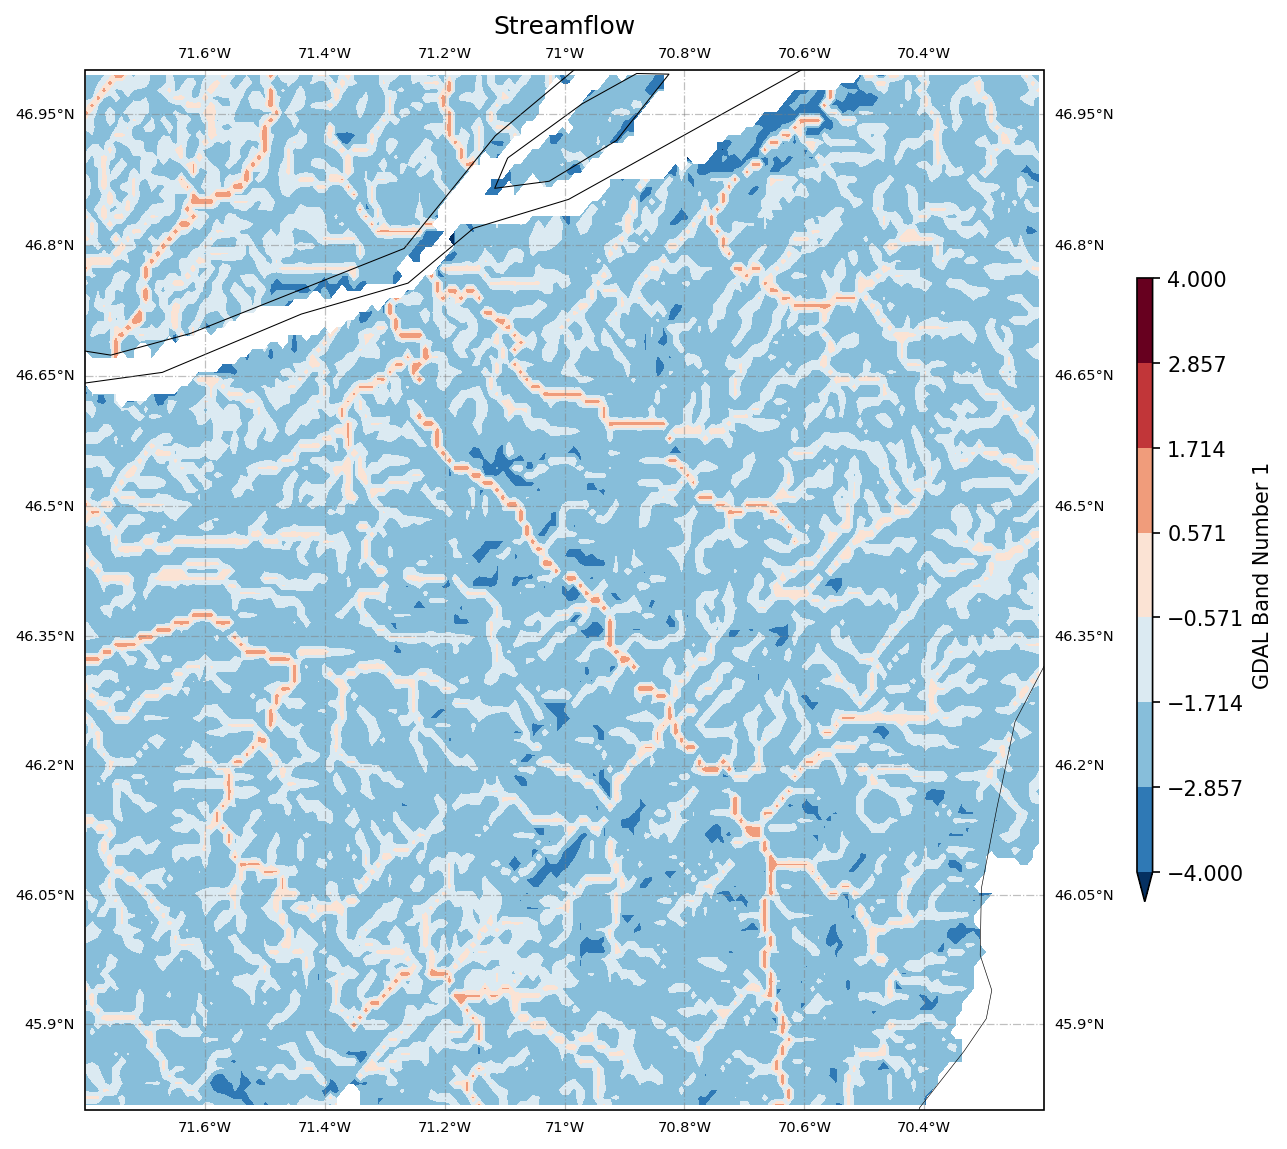

In [ ]:
# plot_dataset(ds.sel(time=first))
plot_dataset(cropped_dataset)


In [3]:
import numpy as np
arr = np.array([1, 2, 3, 4, 5, 6, 2, 0 ,8, 5, 6])
print(arr)
result = np.zeros_like(arr, dtype=float) 
print(result) 


[1 2 3 4 5 6 2 0 8 5 6]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
np.log10(arr, where=arr>0)

array([0.00000000e+00, 3.01029996e-01, 4.77121255e-01, 6.02059991e-01,
       6.98970004e-01, 7.78151250e-01, 3.01029996e-01, 9.80100000e+02,
       9.03089987e-01, 6.98970004e-01, 7.78151250e-01])

In [14]:
from typing import Union

In [15]:
layers = [""] * 3
layers[0] = "EHPS_1km_RiverDischarge-Min3h"
layers[1] = "EHPS_1km_RiverDischarge-Min6h"
layers[2] = "EHPS_1km_RiverDischarge-Min24h" 

In [62]:
def fcst_times_from_wms(
        layers: list[str], 
        username: str=None,
        password: str=None,
    ) -> Union[str, list[str]]:
    """Retrieves the forecast time metadata from the WebMapService for the 
    GeoMet layer (product) of interest.

    Parameters
    ----------
    layers : list [str]
        Name of the GeoMet layer.
    username : str, optional
        Username to access secured layer from WMS API, by default None.
    password : str, optional
        Password to access secured layer from WMS API, by default None.

    Returns
    -------
    Union[str, list[str]]
        The issuse / publication timestamp for the latest forecast.
        A list of timestamps corresponding to the latest forecast's timesteps.
    """
    # 3 layers for the 3 days we will be querying
    first = [''] * len(layers)
    last = [None] * len(layers)
    intvl = [None] * len(layers)
    end_of_day = [None] * len(layers)

    # create a list of forecast datetimes
    hrs = []

    for i in range(0, len(layers)):
        # create WMS object
        wms = WebMapService(
            f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS&LAYERS={layers[i]}',
            version='1.3.0',
            auth=Authentication(username=username, password=password),
            timeout=300
        )

        layer_metadata = wms[layers[i]]
        name = layers[i].split('_')    

        if name[0] == "DHPS" or name[0] == "DHPS-Analysis" or name[0] == "EHPS-Analysis":
            # oldest_fcast = the oldest forecast available from GeoMet, typically b/w 2 and 3 weeks old
            # latest_fcast = the most recently created forecast
            # issue_interval = how frequently the forecasts are published
            oldest_fcast, latest_fcast, issue_interval = layer_metadata.dimensions['reference_time']['values'][0].split('/')

        elif name[0] == "EHPS":
            # oldest_fcast = the oldest forecast available from GeoMet, typically the last couple hours
            # latest_fcast = the most recently created forecast
            # oldest_fcast= wms[layer_name].dimensions['reference_time']['values'][0]
            latest_fcast= layer_metadata.dimensions['reference_time']['values'][-1]

        # the following variables correspond to the latest_fcast issue
        # first_time = the first forecast datetime
        # last_time = the last datetime in the forecast i.e. the extent of the forecast horizon
        # time_interval = the temporal resolution of the forecast
        first_time, last_time, time_interval = layer_metadata.dimensions['time']['values'][0].split('/')

        iso_format = "%Y-%m-%dT%H:%M:%SZ"

        # remove anything that isn't a number from the datetime interval (time between forecasts)
        intvl[i] = int(re.sub(r'\D', '', time_interval))

        # convert date strings to datetime objects
        if i == 0:
            first[i] = datetime.strptime(first_time, iso_format)
        else:
            if i == len(layers)-1:
                first[i] = first[i-1] - timedelta(hours=intvl[i-1])
            else:
                first[i] = first[i-1] - timedelta(hours=intvl[i-1]) + timedelta(hours=intvl[i])
        last[i] = datetime.strptime(last_time, iso_format)

        end_of_day[i] = first[i] + timedelta(hours=(intvl[i] * (24/intvl[i])))

        if i < len(layers):
            # update the list of forecast dates
            while first[i] < end_of_day[i]:
                hrs.append(first[i])
                first[i] = first[i] + timedelta(hours=intvl[i])
        

    # create a list of ISO formatted forecast datetime strings
    fcasthrs = [datetime.strftime(hr, iso_format) for hr in hrs]
    fcasthrs.pop()

    return latest_fcast, fcasthrs

In [63]:
x, y = fcst_times_from_wms(layers=layers, username=login['Username'], password=login['Password'],)
print(x)
print(y)

2024-09-23T00:00:00Z
['2024-09-23T03:00:00Z', '2024-09-23T06:00:00Z', '2024-09-23T09:00:00Z', '2024-09-23T12:00:00Z', '2024-09-23T15:00:00Z', '2024-09-23T18:00:00Z', '2024-09-23T21:00:00Z', '2024-09-24T00:00:00Z', '2024-09-24T06:00:00Z', '2024-09-24T12:00:00Z', '2024-09-24T18:00:00Z', '2024-09-25T00:00:00Z']


In [1]:
import sys
import pandas as pd
import numpy as np
sys.path.append("../../")
import json

In [2]:
from postprocessinglib.evaluation import data, metrics, visuals
from postprocessinglib.forecast import forecast
from postprocessinglib.utilities import _helper_functions as hlp

In [3]:
json_file = 'available_stations.json'
# Load the JSON file
with open(json_file, 'r') as f:
    dt = json.load(f)

# Extract station numbers
station = [feature['properties']['STATION_NUMBER'] for feature in dt['features']]

# Print or use the list
print(station)

['05AA024', '05AC003', '05AD007', '05AG006', '05AJ001', '05BB001', '05BG010', '05BH004', '05BL024', '05BN012', '05CA009', '05CB001', '05CC002', '05CE001', '05CK004', '05DB006', '05DC001', '05DF001', '05EF001', '05FA001', '05FE004', '05GG001', '05HD039', '05HG001', '05KD003', '05KJ001']


In [41]:
from datetime import datetime, timezone
from dateutil.relativedelta import relativedelta
from GeneralProcessing.gen_streamflow_file import GenStreamflowFile
gen_flow = GenStreamflowFile()

# start_date = "1980-03-01"
# end_date   = "2018-01-10"


end_dt = datetime.now(timezone.utc).replace(microsecond=0)
start_dt = end_dt - relativedelta(months=1)
start = start_dt.strftime("%Y-%m-%dT%H:%M:%SZ")
end   = end_dt.strftime("%Y-%m-%dT%H:%M:%SZ")
df_rt, meta_rt = gen_flow.fetch_hydrometric_realtime_full_range(
    station_numbers=station[:5],
    start=start, end=end,
    window_days=1, freq_hours=12
)

Window 2025-06-16–2025-06-17 in 0.9s
Window 2025-06-17–2025-06-18 in 0.9s
Window 2025-06-18–2025-06-19 in 0.9s
Window 2025-06-19–2025-06-20 in 0.9s
Window 2025-06-20–2025-06-21 in 0.9s
Window 2025-06-21–2025-06-22 in 0.9s
Window 2025-06-22–2025-06-23 in 0.9s
Window 2025-06-23–2025-06-24 in 0.9s
Window 2025-06-24–2025-06-25 in 0.9s
Window 2025-06-25–2025-06-26 in 1.0s
Window 2025-06-26–2025-06-27 in 0.9s
Window 2025-06-27–2025-06-28 in 0.9s
Window 2025-06-28–2025-06-29 in 0.9s
Window 2025-06-29–2025-06-30 in 0.9s
Window 2025-06-30–2025-07-01 in 0.9s
Window 2025-07-01–2025-07-02 in 0.9s
Window 2025-07-02–2025-07-03 in 0.9s
Window 2025-07-03–2025-07-04 in 0.9s
Window 2025-07-04–2025-07-05 in 0.9s
Window 2025-07-05–2025-07-06 in 0.9s
Window 2025-07-06–2025-07-07 in 0.9s
Window 2025-07-07–2025-07-08 in 0.9s
Window 2025-07-08–2025-07-09 in 0.9s
Window 2025-07-09–2025-07-10 in 0.9s
Window 2025-07-10–2025-07-11 in 0.9s
Window 2025-07-11–2025-07-12 in 0.9s
Window 2025-07-12–2025-07-13 in 0.9s
W

C:\Users\udenzeU\AppData\Local\anaconda3\envs\postprocessing\Lib\site-packages\GeneralProcessing\gen_streamflow_file.py:420: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample(f"{freq_hours}H")
C:\Users\udenzeU\AppData\Local\anaconda3\envs\postprocessing\Lib\site-packages\GeneralProcessing\gen_streamflow_file.py:420: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample(f"{freq_hours}H")
C:\Users\udenzeU\AppData\Local\anaconda3\envs\postprocessing\Lib\site-packages\GeneralProcessing\gen_streamflow_file.py:420: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample(f"{freq_hours}H")
C:\Users\udenzeU\AppData\Local\anaconda3\envs\postprocessing\Lib\site-packages\GeneralProcessing\gen_streamflow_file.py:420: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample(f"{fre

In [42]:
df_rt

,05AA024,05AC003,05AD007,05AG006,05AJ001
DateTime,,,,,
2025-06-16 12:00:00+00:00,61.171233,2.637534,27.132877,27.413699,82.498630
2025-06-17 00:00:00+00:00,61.213194,2.749583,26.490972,25.831944,100.470833
2025-06-17 12:00:00+00:00,61.375000,2.697708,25.897222,27.598611,91.118056
2025-06-18 00:00:00+00:00,61.164583,2.630208,24.080556,26.704861,74.856944
2025-06-18 12:00:00+00:00,54.654167,2.871250,23.520833,27.892361,85.886806
...,...,...,...,...,...
2025-07-14 12:00:00+00:00,60.150694,6.176736,27.192361,27.205556,46.396528
2025-07-15 00:00:00+00:00,56.346528,5.850069,38.972917,28.222222,44.061806
2025-07-15 12:00:00+00:00,49.093750,2.851597,39.009722,31.093750,42.345833


In [43]:
layer_name = 'DHPS_1km_RiverDischarge'
sim_rt = forecast.main(
    auth_path='../config.cfg',
    stn_list=station[:5],
    layer_name=layer_name, 
    stn_locs_file='available_stations.json'
)


INFO:postprocessinglib.forecast.forecast:Finished forecast queries for station: 05AA024; iteration: 0
INFO:postprocessinglib.forecast.forecast:Finished forecast queries for station: 05AC003; iteration: 1
INFO:postprocessinglib.forecast.forecast:Finished forecast queries for station: 05AD007; iteration: 2
INFO:postprocessinglib.forecast.forecast:Finished forecast queries for station: 05AG006; iteration: 3
INFO:postprocessinglib.forecast.forecast:Finished forecast queries for station: 05AJ001; iteration: 4


In [44]:
sim_rt

,05AA024_sim,05AC003_sim,05AD007_sim,05AG006_sim,05AJ001_sim
time,,,,,
2025-07-16 13:00:00,46.515423,1.479277,38.865707,34.152977,44.306267
2025-07-16 14:00:00,37.042477,1.483850,42.202255,33.621796,43.168011
2025-07-16 15:00:00,33.412296,1.487784,43.524441,33.568298,42.600117
2025-07-16 16:00:00,30.308563,1.490197,44.780869,33.536556,42.097401
2025-07-16 17:00:00,27.912155,1.491525,45.977180,33.498676,41.603054
...,...,...,...,...,...
2025-07-22 08:00:00,32.485146,2.368299,43.280079,75.178802,405.216827
2025-07-22 09:00:00,32.497242,2.347402,43.156414,74.924309,406.977539
2025-07-22 10:00:00,32.510311,2.326619,43.036865,74.635735,408.479584


In [45]:
simcopy = sim_rt.copy()
simcopy.index = simcopy.index.tz_localize('UTC')
simcopy = simcopy.resample('12h').mean()
simcopy

,05AA024_sim,05AC003_sim,05AD007_sim,05AG006_sim,05AJ001_sim
time,,,,,
2025-07-16 12:00:00+00:00,29.607422,1.495017,46.546078,33.498775,41.270515
2025-07-17 00:00:00+00:00,25.205797,1.588025,54.126736,33.236156,36.758312
2025-07-17 12:00:00+00:00,26.173899,1.672988,58.672634,34.193203,33.791290
2025-07-18 00:00:00+00:00,27.058004,1.640521,62.727100,36.723736,34.431973
2025-07-18 12:00:00+00:00,27.775826,1.524882,63.527676,43.983463,33.278759
2025-07-19 00:00:00+00:00,28.581902,1.419501,57.154774,47.577255,30.638906
2025-07-19 12:00:00+00:00,29.359838,1.438707,47.799061,50.856995,39.533077
2025-07-20 00:00:00+00:00,30.151381,1.628266,43.248241,59.990311,99.808266
2025-07-20 12:00:00+00:00,30.815859,1.931592,43.710720,67.019714,158.152298


In [46]:
obs = df_rt.copy()

merged_cols = []
# new_column_names = []

for col1, col2 in zip(obs.columns, simcopy.columns):
    merged_cols.append(obs[col1])
    merged_cols.append(simcopy[col2])
#     new_column_names.extend([col1, col2])
    
merged = pd.concat(merged_cols, axis=1)
# merged.columns = new_column_names
# for col in merged:
#     merged = pd.concat([merged, sim[[col]]], axis = 1)
# merged.join(sim)
# merged = df_rt.set_index(df_rt.index).join(sim).reset_index()
    
# merged=merged.iloc[:, :-2]
merged

,05AA024,05AA024_sim,05AC003,05AC003_sim,05AD007,05AD007_sim,05AG006,05AG006_sim,05AJ001,05AJ001_sim
2025-06-16 12:00:00+00:00,61.171233,NaN,2.637534,NaN,27.132877,NaN,27.413699,NaN,82.498630,NaN
2025-06-17 00:00:00+00:00,61.213194,NaN,2.749583,NaN,26.490972,NaN,25.831944,NaN,100.470833,NaN
2025-06-17 12:00:00+00:00,61.375000,NaN,2.697708,NaN,25.897222,NaN,27.598611,NaN,91.118056,NaN
2025-06-18 00:00:00+00:00,61.164583,NaN,2.630208,NaN,24.080556,NaN,26.704861,NaN,74.856944,NaN
2025-06-18 12:00:00+00:00,54.654167,NaN,2.871250,NaN,23.520833,NaN,27.892361,NaN,85.886806,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-07-20 12:00:00+00:00,NaN,30.815859,NaN,1.931592,NaN,43.710720,NaN,67.019714,NaN,158.152298
2025-07-21 00:00:00+00:00,NaN,31.425034,NaN,2.382698,NaN,45.750507,NaN,72.529999,NaN,225.642456
2025-07-21 12:00:00+00:00,NaN,31.874640,NaN,2.570146,NaN,45.290680,NaN,76.017738,NaN,335.449677
2025-07-22 00:00:00+00:00,NaN,32.292049,NaN,2.416279,NaN,43.621506,NaN,75.500114,NaN,397.733612


In [47]:
from collections import defaultdict
import pandas as pd

# Modify df.columns to be a MultiIndex
def set_multiindex_columns(df):
    station_counts = defaultdict(int)
    multi_cols = []

    for col in df.columns:
        station = col.split('_')[0]
        count = station_counts[station]

        if count == 0:
            label = 'QOMEAS'
        elif count == 1 and col.endswith('_sim'):
            label = 'QOSIM'
        else:
            label = f'QOSIM{count}'

        station_counts[station] += 1
        multi_cols.append((station, label))

    # Apply MultiIndex to the DataFrame columns
    df.columns = pd.MultiIndex.from_tuples(multi_cols)
    return df

merged = set_multiindex_columns(merged)
merged

05AA024              05AC003            \
                              QOMEAS      QOSIM    QOMEAS     QOSIM   
2025-06-16 12:00:00+00:00  61.171233        NaN  2.637534       NaN   
2025-06-17 00:00:00+00:00  61.213194        NaN  2.749583       NaN   
2025-06-17 12:00:00+00:00  61.375000        NaN  2.697708       NaN   
2025-06-18 00:00:00+00:00  61.164583        NaN  2.630208       NaN   
2025-06-18 12:00:00+00:00  54.654167        NaN  2.871250       NaN   
...                              ...        ...       ...       ...   
2025-07-20 12:00:00+00:00        NaN  30.815859       NaN  1.931592   
2025-07-21 00:00:00+00:00        NaN  31.425034       NaN  2.382698   
2025-07-21 12:00:00+00:00        NaN  31.874640       NaN  2.570146   
2025-07-22 00:00:00+00:00        NaN  32.292049       NaN  2.416279   
2025-07-22 12:00:00+00:00        NaN  32.531227       NaN  2.286629   

                             05AD007               05AG006             \
                              QOMEAS      QOSIM     QOMEAS      QOSIM   
2025-06-16 12:00:00+00:00  27.132877        NaN  27.413699        NaN   
2025-06-17 00:00:00+00:00  26.490972        NaN  25.831944        NaN   
2025-06-17 12:00:00+00:00  25.897222        NaN  27.598611        NaN   
2025-06-18 00:00:00+00:00  24.080556        NaN  26.704861        NaN   
2025-06-18 12:00:00+00:00  23.520833        NaN  27.892361        NaN   
...                              ...        ...        ...        ...   
2025-07-20 12:00:00+00:00        NaN  43.710720        NaN  67.019714   
2025-07-21 00:00:00+00:00        NaN  45.750507        NaN  72.529999   
2025-07-21 12:00:00+00:00        NaN  45.290680        NaN  76.017738   
2025-07-22 00:00:00+00:00        NaN  43.621506        NaN  75.500114   
2025-07-22 12:00:00+00:00        NaN  42.808311        NaN  73.960770   

                              05AJ001              
                               QOMEAS       QOSIM  
2025-06-16 12:00:00+00:00   82.498630         NaN  
2025-06-17 00:00:00+00:00  100.470833         NaN  
2025-06-17 12:00:00+00:00   91.118056         NaN  
2025-06-18 00:00:00+00:00   74.856944         NaN  
2025-06-18 12:00:00+00:00   85.886806         NaN  
...                               ...         ...  
2025-07-20 12:00:00+00:00         NaN  158.152298  
2025-07-21 00:00:00+00:00         NaN  225.642456  
2025-07-21 12:00:00+00:00         NaN  335.449677  
2025-07-22 00:00:00+00:00         NaN  397.733612  
2025-07-22 12:00:00+00:00         NaN  410.833221  

[73 rows x 10 columns]

In [48]:
# merged.iloc[:, :4]

Number of simulated data columns: 1
Number of linewidths provided is less than the number of columns. Number of columns : 2. Number of linewidths provided is:  1. Defaulting to 1.5
Number of linestyles provided is less than the number of columns. Number of columns : 2. Number of linestyles provided is:  1. Defaulting to solid lines (-)


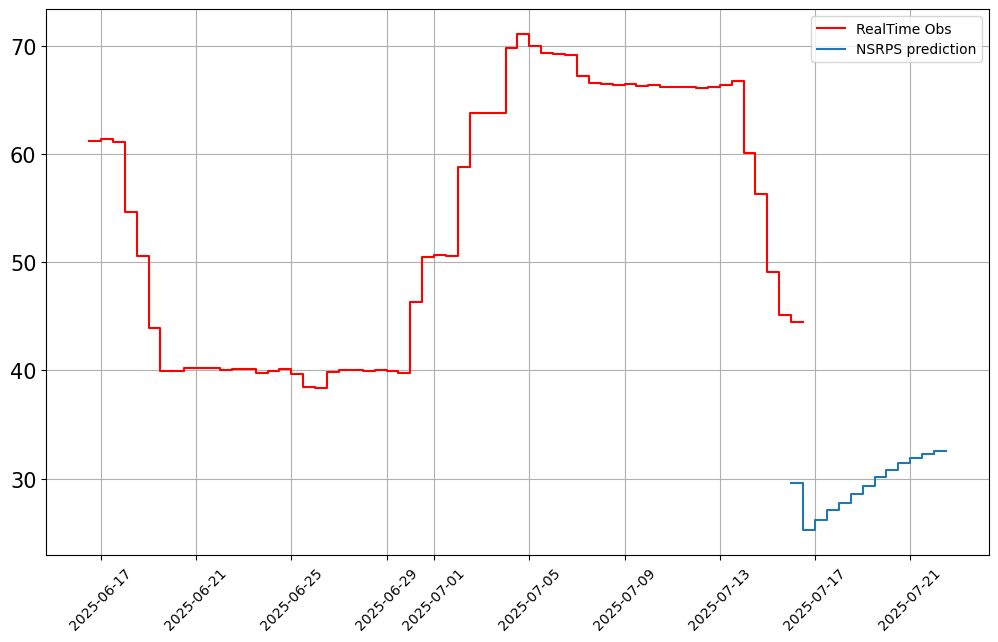

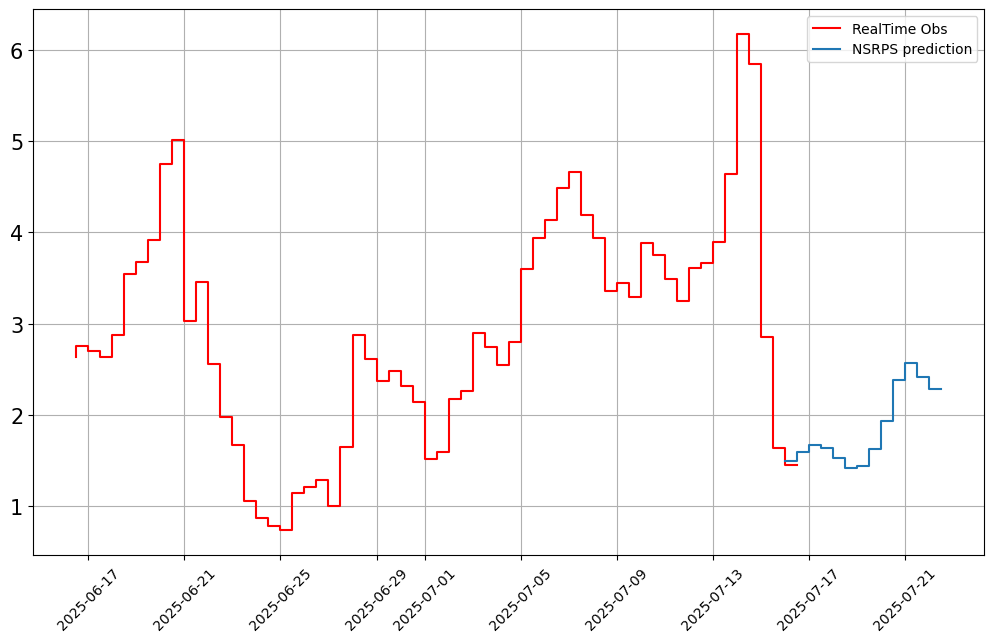

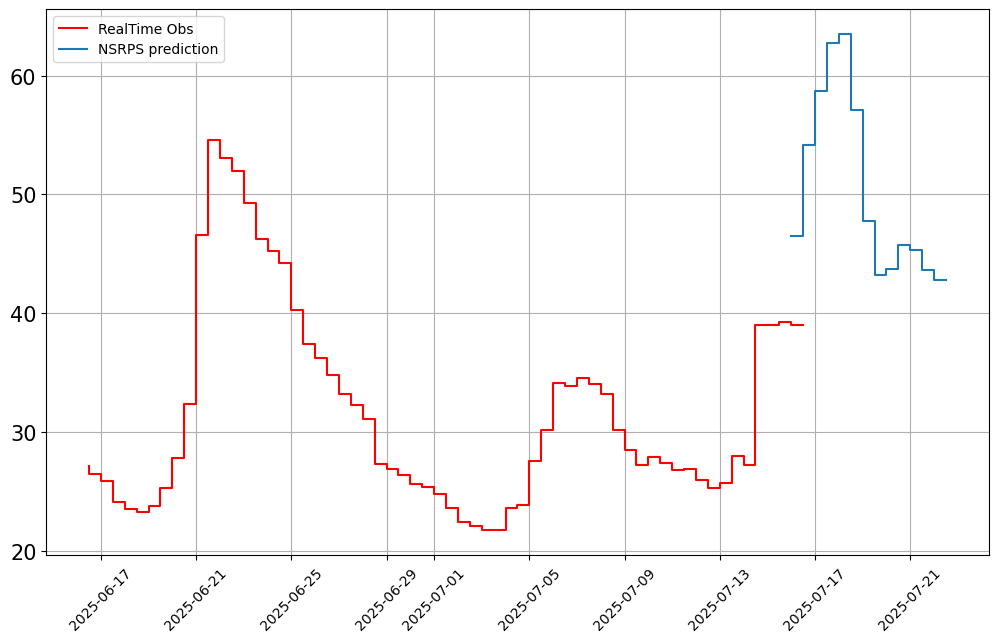

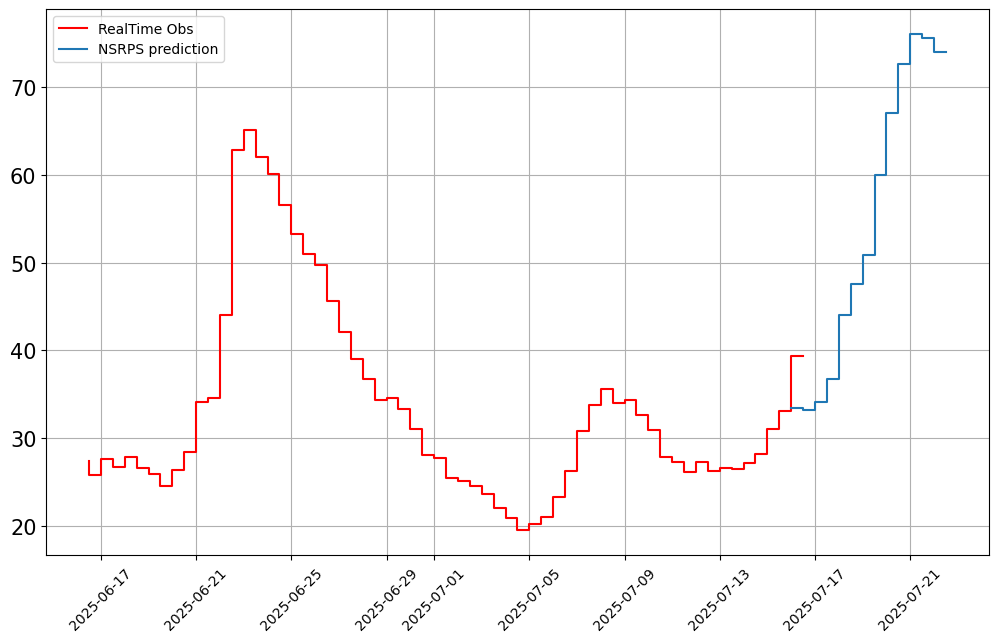

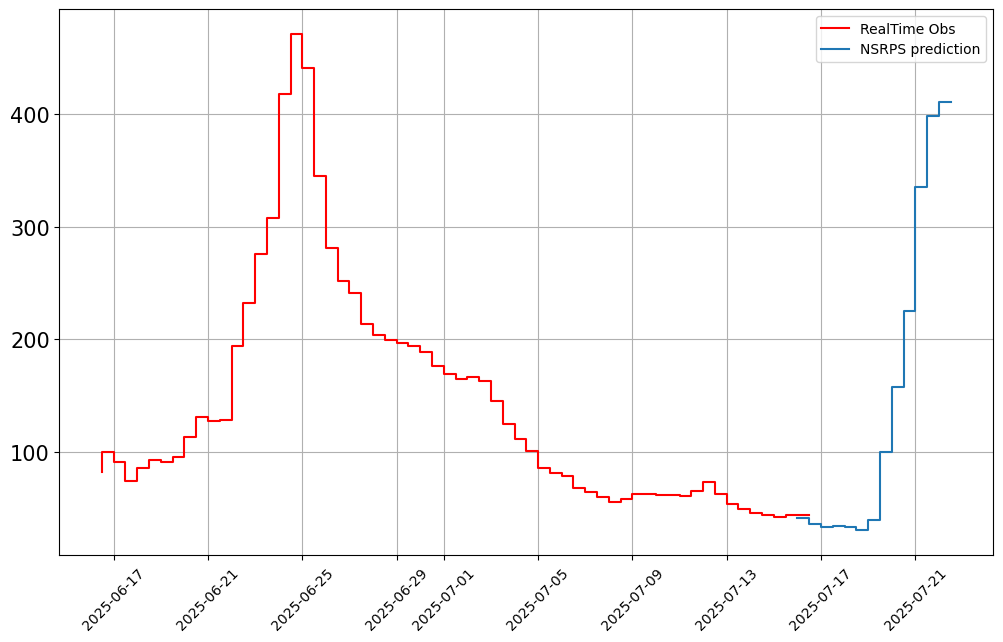

In [49]:
visuals.plot(merged_df = merged, step = True, grid = True, legend = ["RealTime Obs", "NSRPS prediction"])

In [50]:
# import matplotlib.pyplot as plt

# for i in range(0, len(merged.columns), 2):
#     plt.figure(figsize=(10, 5))
#     cols = merged.columns[i:i+2]
    
#     for col in cols:
#         plt.step(merged.index, merged[col], label=col)
    
#     plt.legend()
#     plt.xlabel('Time')
#     plt.ylabel('Value')
#     plt.title(f'Step Plot of Station: {", ".join(cols)}')
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

In [52]:
# df = pd.read_csv("./NSRPS_PRED/merged_streamflow_data_2025-07-09_17-37-28.csv", header=[0, 1], index_col=0, parse_dates=True)
# df

In [53]:
# print(sys.executable)

In [54]:
from datetime import datetime, timezone
from dateutil.relativedelta import relativedelta
from GeneralProcessing.gen_streamflow_file import GenStreamflowFile
gen_flow = GenStreamflowFile()

start_date = "1980-01-01"
end_date   = "2024-12-12"
# Historical daily‐mean (1980–2018)
station_ca = station[:5]
df_ca, meta_ca = gen_flow.fetch_hydrometric_data_ca(station_ca, start_date, end_date)
df_ca

Fetched daily‐mean for 05AA024 in 7.0s
Fetched daily‐mean for 05AC003 in 7.7s
Fetched daily‐mean for 05AD007 in 7.7s
Fetched daily‐mean for 05AG006 in 6.8s
Fetched daily‐mean for 05AJ001 in 7.4s
Fetched metadata for 05AA024 in 0.2s
Fetched metadata for 05AC003 in 0.2s
Fetched metadata for 05AD007 in 0.2s
Fetched metadata for 05AG006 in 0.2s
Fetched metadata for 05AJ001 in 0.2s


,05AA024,05AC003,05AD007,05AG006,05AJ001
Date,,,,,
1980-01-01,3.75,None,5.65,None,56.0
1980-01-02,3.62,None,5.5,None,54.799999
1980-01-03,3.5,None,5.38,None,51.0
1980-01-04,3.4,None,5.22,None,48.099998
1980-01-05,3.28,None,5.05,None,45.700001
...,...,...,...,...,...
2024-12-08,None,None,None,None,None
2024-12-09,None,None,None,None,None
2024-12-10,None,None,None,None,None


In [64]:
lt_mean = data.long_term_seasonal(df=df_ca, method = 'mean')
lt_max = data.long_term_seasonal(df=df_ca, method = 'max')
lt_min = data.long_term_seasonal(df=df_ca, method = 'min')
lt_median = data.long_term_seasonal(df=df_ca , method = 'median')

for i in station[:5]:
    df_ca[i] = pd.to_numeric(df_ca[i], errors='coerce')


lt_q95 = data.long_term_seasonal(df=df_ca , method = 'Q95')
lt_q5 = data.long_term_seasonal(df=df_ca , method = 'q5')
lt_q75 = data.long_term_seasonal(df=df_ca , method = 'Q75')
lt_q25 = data.long_term_seasonal(df=df_ca , method = 'q25')

In [ ]:
# lt_q95.plot()

In [ ]:
# df_ca.plot()

<Axes: xlabel='Date'>

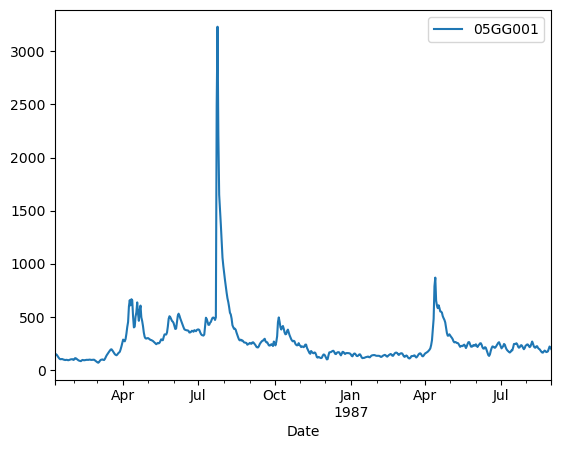

In [20]:
# df_ca.iloc[2200:2800].plot()

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
# # --- Your DataFrames ---
# # long_term_df: 366-day seasonal climatology with index = jday (1-366) agg. by median
# # long_term_df_2: 366-day seasonal climatology with index = jday (1-366) agg. by the 95th quartile
# # long_term_df_3: 366-day seasonal climatology with index = jday (1-366) agg. by the 5th quartile
# # short_term_df: datetime-indexed 30-something day data

# short_term_df = merged
# long_term_df = lt_median
# long_term_df_2 = lt_q95
# long_term_df_3 = lt_q5
# short_term_subset = short_term_df.loc[:, short_term_df.columns.get_level_values(0) == '05GG001']
# # print(short_term_subset)


# # Step 1: Extract jdays from short_term_df
# short_term_jdays = short_term_df.index.dayofyear
# print(short_term_jdays)

# # Step 2: Subset long_term_df to only those jdays
# subset_climatology_2 = long_term_df_2.loc[long_term_df_2.index.isin(short_term_jdays)]
# subset_climatology_3 = long_term_df_3.loc[long_term_df_3.index.isin(short_term_jdays)]
# subset_climatology = long_term_df.loc[long_term_df.index.isin(short_term_jdays)]
# # print(subset_climatology_2)
# # print(subset_climatology_3)


# # Step 3: Repeat the `long_term_df` values for each day to match `short_term_df` (2 per day)
# # Create a new index by repeating each day for two timepoints (00:00, 12:00)
# expanded_climatology = pd.DataFrame(index=short_term_df.index)
# expanded_climatology_2 = pd.DataFrame(index=short_term_df.index)
# expanded_climatology_3 = pd.DataFrame(index=short_term_df.index)

# # Loop through each column and repeat the climatology values to match short_term_df
# for col in subset_climatology.columns:
#     # Get the climatology values for each jday (one per day)
#     climatology_values = subset_climatology[col].values
    
#     # Repeat each climatology value twice (00:00 and 12:00) to match short_term_df
#     repeated_values = climatology_values.repeat(2)
    
#     # Ensure the length of repeated values matches the length of short_term_df
#     expanded_climatology[col] = repeated_values[:len(short_term_df)]

# # Loop through each column and repeat the climatology values to match short_term_df
# for col in subset_climatology_2.columns:
#     # Get the climatology values for each jday (one per day)
#     climatology_values = subset_climatology_2[col].values
    
#     # Repeat each climatology value twice (00:00 and 12:00) to match short_term_df
#     repeated_values = climatology_values.repeat(2)
    
#     # Ensure the length of repeated values matches the length of short_term_df
#     expanded_climatology_2[col] = repeated_values[:len(short_term_df)]
    
# # Loop through each column and repeat the climatology values to match short_term_df
# for col in subset_climatology_3.columns:
#     # Get the climatology values for each jday (one per day)
#     climatology_values = subset_climatology_3[col].values
    
#     # Repeat each climatology value twice (00:00 and 12:00) to match short_term_df
#     repeated_values = climatology_values.repeat(2)
    
#     # Ensure the length of repeated values matches the length of short_term_df
#     expanded_climatology_3[col] = repeated_values[:len(short_term_df)]

# # --- Check and Drop Last Row in expanded_climatology if Incomplete ---
# # If `short_term_df` has an odd number of entries (last day incomplete), drop the last row in expanded_climatology
# if len(short_term_df) % 2 != 0:
#     expanded_climatology = expanded_climatology.iloc[:-1]
#     expanded_climatology_2 = expanded_climatology_2.iloc[:-1]
#     expanded_climatology_3 = expanded_climatology_3.iloc[:-1]

# # print(expanded_climatology_2)
# # print(expanded_climatology_3)
# # print(short_term_df)

# # --- Convert the values to numeric just in case ---
# expanded_climatology[i for i in station[:5]] = pd.to_numeric(expanded_climatology[i for i i in station[:5]], errors='coerce')
# expanded_climatology_2[i for i  in station[:5]] = pd.to_numeric(expanded_climatology_2[i for i in station[:5]], errors='coerce')
# expanded_climatology_3[i for i in station[:5]] = pd.to_numeric(expanded_climatology_3[i for i in station[:5]], errors='coerce')
# print(expanded_climatology)
# print(expanded_climatology_2)
# print(expanded_climatology_3)

# # # Step 4: Plot
# # plt.figure(figsize=(10, 5))
# fig, ax = plt.subplots(figsize=(10, 5))

# # Plot QOMEAS (for 'MEAS') and QOSIM (for 'SIM')
# # Plot for 'QOMEAS' (MEAS)
# ax.step(short_term_subset.index, short_term_subset['05GG001']['QOMEAS'], label='QOMEAS (Observed - MEAS)', color='blue')

# # Plot for 'QOSIM' (SIM)
# ax.step(short_term_subset.index, short_term_subset['05GG001']['QOSIM'], label='QOSIM (Observed - SIM)', color='green')

# # Plot for the Median
# ax.step(short_term_subset.index, expanded_climatology['05GG001'], label='Median', color='red')

# # Plot climatology for 'MEAS' (Climatology data) - same for both MEAS and SIM
# ax.fill_between(expanded_climatology_2.index, expanded_climatology_2['05GG001'], 
#                 expanded_climatology_3['05GG001'], alpha = 0.3, 
#                 label='Climatology (MEAS/SIM)', color='orange')



# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.title('Observed vs Climatological Seasonal Signal')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


<Axes: xlabel='jday'>

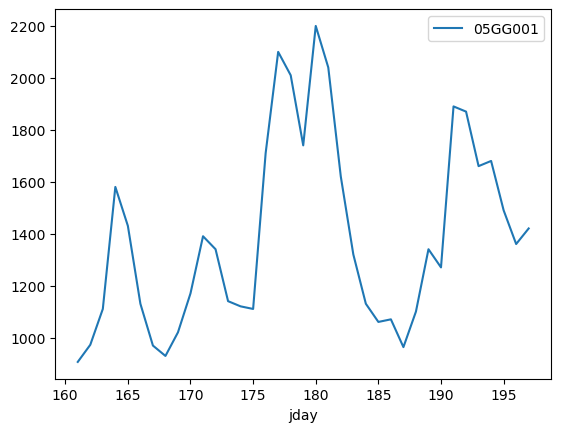

In [22]:
# lt_max.iloc[160:197:].plot()

In [65]:
def prepare_dataframes(short_term_df, long_term_df, upper_bounds_dfs, lower_bounds_dfs):
    """
    Prepare climatology DataFrames expanded to match timestamps of short_term_df,
    with separate lists of upper and lower bound DataFrames.

    Args:
      short_term_df: DataFrame with datetime index.
      long_term_df: DataFrame indexed by jday (1-366) for median or central tendency.
      upper_bounds_dfs: List of DataFrames indexed by jday (1-366) for upper bounds (e.g. q95, max, q75).
      lower_bounds_dfs: List of DataFrames indexed by jday (1-366) for lower bounds (e.g. q5, min, q25).

    Returns:
      expanded_climatology: DataFrame with same index as short_term_df (median/centerline)
      expanded_upper_bounds: List of DataFrames with same index as short_term_df (upper bounds)
      expanded_lower_bounds: List of DataFrames with same index as short_term_df (lower bounds)
    """
    import pandas as pd

    # Extract day of year (jday) for each timestamp in short_term_df
    jdays = short_term_df.index.dayofyear

    # Map median climatology values from jday to timestamps
    expanded_climatology = long_term_df.reindex(jdays).set_index(short_term_df.index)

    # Map each upper bound climatology similarly
    expanded_upper_bounds = []
    for upper_df in upper_bounds_dfs:
        expanded_upper = upper_df.reindex(jdays).set_index(short_term_df.index)
        expanded_upper_bounds.append(expanded_upper)

    # Map each lower bound climatology similarly
    expanded_lower_bounds = []
    for lower_df in lower_bounds_dfs:
        expanded_lower = lower_df.reindex(jdays).set_index(short_term_df.index)
        expanded_lower_bounds.append(expanded_lower)

    return expanded_climatology, expanded_upper_bounds, expanded_lower_bounds


In [66]:
median, upper, lower = prepare_dataframes(merged, lt_median, [lt_q95, lt_q75], [lt_q5, lt_q25])

In [67]:
merged

05AA024              05AC003            \
                              QOMEAS      QOSIM    QOMEAS     QOSIM   
2025-06-16 12:00:00+00:00  61.171233        NaN  2.637534       NaN   
2025-06-17 00:00:00+00:00  61.213194        NaN  2.749583       NaN   
2025-06-17 12:00:00+00:00  61.375000        NaN  2.697708       NaN   
2025-06-18 00:00:00+00:00  61.164583        NaN  2.630208       NaN   
2025-06-18 12:00:00+00:00  54.654167        NaN  2.871250       NaN   
...                              ...        ...       ...       ...   
2025-07-20 12:00:00+00:00        NaN  30.815859       NaN  1.931592   
2025-07-21 00:00:00+00:00        NaN  31.425034       NaN  2.382698   
2025-07-21 12:00:00+00:00        NaN  31.874640       NaN  2.570146   
2025-07-22 00:00:00+00:00        NaN  32.292049       NaN  2.416279   
2025-07-22 12:00:00+00:00        NaN  32.531227       NaN  2.286629   

                             05AD007               05AG006             \
                              QOMEAS      QOSIM     QOMEAS      QOSIM   
2025-06-16 12:00:00+00:00  27.132877        NaN  27.413699        NaN   
2025-06-17 00:00:00+00:00  26.490972        NaN  25.831944        NaN   
2025-06-17 12:00:00+00:00  25.897222        NaN  27.598611        NaN   
2025-06-18 00:00:00+00:00  24.080556        NaN  26.704861        NaN   
2025-06-18 12:00:00+00:00  23.520833        NaN  27.892361        NaN   
...                              ...        ...        ...        ...   
2025-07-20 12:00:00+00:00        NaN  43.710720        NaN  67.019714   
2025-07-21 00:00:00+00:00        NaN  45.750507        NaN  72.529999   
2025-07-21 12:00:00+00:00        NaN  45.290680        NaN  76.017738   
2025-07-22 00:00:00+00:00        NaN  43.621506        NaN  75.500114   
2025-07-22 12:00:00+00:00        NaN  42.808311        NaN  73.960770   

                              05AJ001              
                               QOMEAS       QOSIM  
2025-06-16 12:00:00+00:00   82.498630         NaN  
2025-06-17 00:00:00+00:00  100.470833         NaN  
2025-06-17 12:00:00+00:00   91.118056         NaN  
2025-06-18 00:00:00+00:00   74.856944         NaN  
2025-06-18 12:00:00+00:00   85.886806         NaN  
...                               ...         ...  
2025-07-20 12:00:00+00:00         NaN  158.152298  
2025-07-21 00:00:00+00:00         NaN  225.642456  
2025-07-21 12:00:00+00:00         NaN  335.449677  
2025-07-22 00:00:00+00:00         NaN  397.733612  
2025-07-22 12:00:00+00:00         NaN  410.833221  

[73 rows x 10 columns]

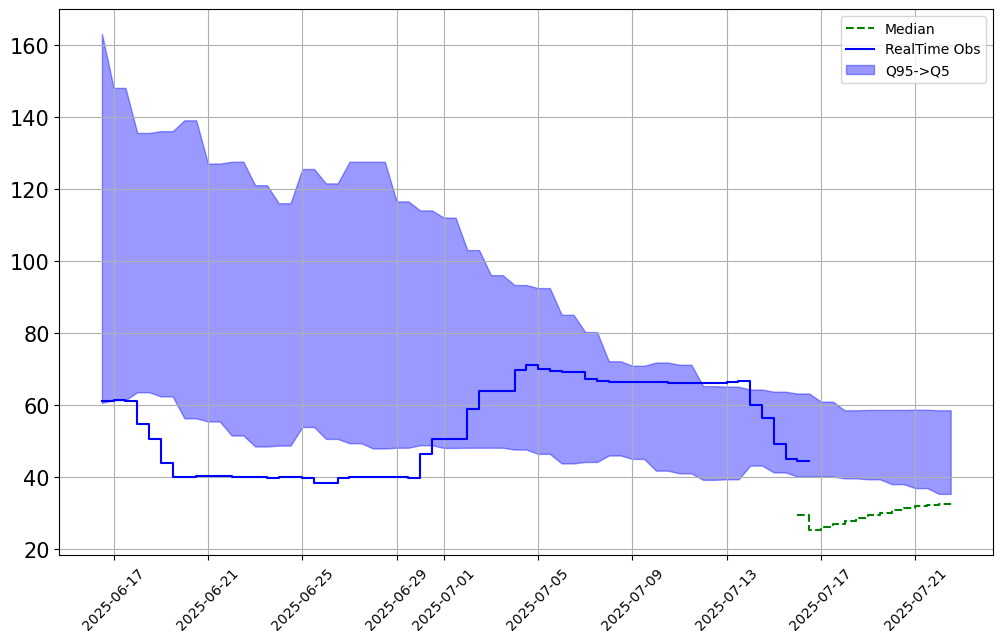

In [70]:
visuals.bounded_plot(lines=merged.iloc[:, [0]], upper_bounds=upper[1], lower_bounds=lower[1], extra_lines=merged.iloc[:, [1]], grid = True, step = True,
                     legend = ["Median","RealTime Obs", "NSRPS prediction"], bound_legend= ["Q95->Q5","Q75->Q25"], linestyles=["g-","b-"])

In [25]:
df_past = pd.read_csv("./NSRPS_PRED/merged_streamflow_data_2025-07-11_14-34-53.csv", header=[0, 1], index_col=0, parse_dates=True)
df_past.head(20)

05AA024         05AC003          05AD007        \
                              QOMEAS QOSIM    QOMEAS QOSIM     QOMEAS QOSIM   
2025-06-11 12:00:00+00:00  58.009091   NaN  1.886545   NaN  21.920000   NaN   
2025-06-12 00:00:00+00:00  62.852083   NaN  1.782014   NaN  22.306250   NaN   
2025-06-12 12:00:00+00:00  63.534722   NaN  1.789306   NaN  23.045139   NaN   
2025-06-13 00:00:00+00:00  63.561111   NaN  2.136458   NaN  24.330556   NaN   
2025-06-13 12:00:00+00:00  63.604167   NaN  2.902083   NaN  27.645139   NaN   
2025-06-14 00:00:00+00:00  63.538194   NaN  3.058194   NaN  26.606250   NaN   
2025-06-14 12:00:00+00:00  63.536111   NaN  2.333333   NaN  26.508333   NaN   
2025-06-15 00:00:00+00:00  63.544444   NaN  2.146389   NaN  25.683333   NaN   
2025-06-15 12:00:00+00:00  63.504861   NaN  2.537500   NaN  26.252083   NaN   
2025-06-16 00:00:00+00:00  63.486111   NaN  2.676667   NaN  26.554861   NaN   
2025-06-16 12:00:00+00:00  61.987500   NaN  2.704375   NaN  27.076389   NaN   
2025-06-17 00:00:00+00:00  61.409722   NaN  2.749583   NaN  26.490972   NaN   
2025-06-17 12:00:00+00:00  61.574306   NaN  2.697708   NaN  25.897222   NaN   
2025-06-18 00:00:00+00:00  61.364583   NaN  2.630208   NaN  24.080556   NaN   
2025-06-18 12:00:00+00:00  54.854167   NaN  2.871250   NaN  23.520833   NaN   
2025-06-19 00:00:00+00:00  50.754861   NaN  3.547500   NaN  23.303472   NaN   
2025-06-19 12:00:00+00:00  44.073611   NaN  3.674931   NaN  23.765278   NaN   
2025-06-20 00:00:00+00:00  40.144444   NaN  3.918958   NaN  25.249306   NaN   
2025-06-20 12:00:00+00:00  40.158333   NaN  4.749792   NaN  27.780556   NaN   
2025-06-21 00:00:00+00:00  40.384722   NaN  5.007292   NaN  32.373611   NaN   

                             05AG006           05AJ001        ...     05GG001  \
                              QOMEAS QOSIM      QOMEAS QOSIM  ...      QOMEAS   
2025-06-11 12:00:00+00:00  22.245455   NaN   51.550909   NaN  ...  206.109091   
2025-06-12 00:00:00+00:00  21.045833   NaN   48.636806   NaN  ...  204.187500   
2025-06-12 12:00:00+00:00  21.904167   NaN   43.906944   NaN  ...  203.142857   
2025-06-13 00:00:00+00:00  22.246528   NaN   40.865278   NaN  ...  201.916084   
2025-06-13 12:00:00+00:00  22.936806   NaN   39.010417   NaN  ...  200.798611   
2025-06-14 00:00:00+00:00  23.661806   NaN   39.460417   NaN  ...  201.013889   
2025-06-14 12:00:00+00:00  24.522222   NaN   40.145139   NaN  ...  205.479167   
2025-06-15 00:00:00+00:00  25.834028   NaN   41.791667   NaN  ...  206.423611   
2025-06-15 12:00:00+00:00  28.674306   NaN   53.824306   NaN  ...  206.930556   
2025-06-16 00:00:00+00:00  27.917361   NaN   76.656250   NaN  ...  202.451389   
2025-06-16 12:00:00+00:00  27.461806   NaN   82.784615   NaN  ...  197.978723   
2025-06-17 00:00:00+00:00  25.831944   NaN  100.470833   NaN  ...  191.993056   
2025-06-17 12:00:00+00:00  27.598611   NaN   91.118056   NaN  ...  185.222222   
2025-06-18 00:00:00+00:00  26.704861   NaN   74.856944   NaN  ...  179.527778   
2025-06-18 12:00:00+00:00  27.892361   NaN   85.886806   NaN  ...  184.437500   
2025-06-19 00:00:00+00:00  26.683333   NaN   92.995833   NaN  ...  191.770833   
2025-06-19 12:00:00+00:00  25.926389   NaN   90.913889   NaN  ...  194.048611   
2025-06-20 00:00:00+00:00  24.568750   NaN   96.161806   NaN  ...  193.777778   
2025-06-20 12:00:00+00:00  26.355556   NaN  113.548611   NaN  ...  192.097222   
2025-06-21 00:00:00+00:00  28.461111   NaN  131.270833   NaN  ...  190.833333   

                                  05HD039          05HG001           05KD003  \
                          QOSIM    QOMEAS QOSIM     QOMEAS QOSIM      QOMEAS   
2025-06-11 12:00:00+00:00   NaN  0.630291   NaN  73.274545   NaN  514.600000   
2025-06-12 00:00:00+00:00   NaN  0.679243   NaN  72.361111   NaN  278.729167   
2025-06-12 12:00:00+00:00   NaN  0.632181   NaN  73.863194   NaN  303.708333   
2025-06-13 00:00:00+00:00   NaN  0.620132   NaN  78.609722   NaN  225.013889   
2025-06-13 12:00:00+00:00  

In [26]:
df_future = pd.read_csv("./NSRPS_PRED/merged_streamflow_data_2025-07-17_12-02-05.csv", header=[0, 1], index_col=0, parse_dates=True)
df_future.head(20)

05AA024         05AC003          05AD007        \
                              QOMEAS QOSIM    QOMEAS QOSIM     QOMEAS QOSIM   
2025-06-17 12:00:00+00:00  61.327632   NaN  2.663289   NaN  25.588158   NaN   
2025-06-18 00:00:00+00:00  61.164583   NaN  2.630208   NaN  23.875000   NaN   
2025-06-18 12:00:00+00:00  54.654167   NaN  2.871250   NaN  23.320833   NaN   
2025-06-19 00:00:00+00:00  50.554861   NaN  3.547500   NaN  23.082639   NaN   
2025-06-19 12:00:00+00:00  43.897917   NaN  3.674931   NaN  23.524306   NaN   
2025-06-20 00:00:00+00:00  39.976389   NaN  3.918958   NaN  24.990972   NaN   
2025-06-20 12:00:00+00:00  39.977778   NaN  4.749792   NaN  27.495833   NaN   
2025-06-21 00:00:00+00:00  40.213194   NaN  5.007292   NaN  32.052083   NaN   
2025-06-21 12:00:00+00:00  40.266667   NaN  3.032153   NaN  46.234028   NaN   
2025-06-22 00:00:00+00:00  40.186806   NaN  3.457778   NaN  54.135417   NaN   
2025-06-22 12:00:00+00:00  40.019444   NaN  2.551250   NaN  52.623611   NaN   
2025-06-23 00:00:00+00:00  40.088889   NaN  1.978056   NaN  51.522222   NaN   
2025-06-23 12:00:00+00:00  40.118750   NaN  1.664306   NaN  48.819444   NaN   
2025-06-24 00:00:00+00:00  39.805556   NaN  1.052854   NaN  45.731944   NaN   
2025-06-24 12:00:00+00:00  39.937500   NaN  0.872056   NaN  44.795139   NaN   
2025-06-25 00:00:00+00:00  40.099306   NaN  0.775396   NaN  43.718056   NaN   
2025-06-25 12:00:00+00:00  39.711111   NaN  0.730938   NaN  39.754861   NaN   
2025-06-26 00:00:00+00:00  38.495833   NaN  1.144493   NaN  36.938889   NaN   
2025-06-26 12:00:00+00:00  38.354861   NaN  1.202500   NaN  35.761806   NaN   
2025-06-27 00:00:00+00:00  39.822917   NaN  1.281597   NaN  34.279167   NaN   

                             05AG006           05AJ001        ...     05GG001  \
                              QOMEAS QOSIM      QOMEAS QOSIM  ...      QOMEAS   
2025-06-17 12:00:00+00:00  27.707895   NaN   85.703947   NaN  ...  181.078947   
2025-06-18 00:00:00+00:00  26.704861   NaN   74.856944   NaN  ...  177.375000   
2025-06-18 12:00:00+00:00  27.892361   NaN   85.886806   NaN  ...  182.083333   
2025-06-19 00:00:00+00:00  26.683333   NaN   92.995833   NaN  ...  189.500000   
2025-06-19 12:00:00+00:00  25.926389   NaN   90.913889   NaN  ...  191.611111   
2025-06-20 00:00:00+00:00  24.568750   NaN   96.161806   NaN  ...  191.090278   
2025-06-20 12:00:00+00:00  26.355556   NaN  113.548611   NaN  ...  189.666667   
2025-06-21 00:00:00+00:00  28.461111   NaN  131.270833   NaN  ...  188.319444   
2025-06-21 12:00:00+00:00  34.106944   NaN  128.006944   NaN  ...  195.777778   
2025-06-22 00:00:00+00:00  34.572917   NaN  128.402778   NaN  ...  224.125000   
2025-06-22 12:00:00+00:00  44.011111   NaN  194.625000   NaN  ...  251.409722   
2025-06-23 00:00:00+00:00  62.786111   NaN  232.701389   NaN  ...  248.548611   
2025-06-23 12:00:00+00:00  65.081944   NaN  275.881944   NaN  ...  236.583333   
2025-06-24 00:00:00+00:00  61.972917   NaN  307.861111   NaN  ...  230.743056   
2025-06-24 12:00:00+00:00  60.070833   NaN  417.826389   NaN  ...  232.402778   
2025-06-25 00:00:00+00:00  56.538194   NaN  470.972222   NaN  ...  230.881944   
2025-06-25 12:00:00+00:00  53.261111   NaN  440.628571   NaN  ...  228.951389   
2025-06-26 00:00:00+00:00  51.004861   NaN  344.500000   NaN  ...  244.201389   
2025-06-26 12:00:00+00:00  49.734722   NaN  281.270833   NaN  ...  255.062500   
2025-06-27 00:00:00+00:00  45.641667   NaN  252.055556   NaN  ...  257.562500   

                                  05HD039          05HG001           05KD003  \
                          QOSIM    QOMEAS QOSIM     QOMEAS QOSIM      QOMEAS   
2025-06-17 12:00:00+00:00   NaN  0.699447   NaN  76.946053   NaN  418.618421   
2025-06-18 00:00:00+00:00   NaN  0.778312   NaN  78.643056   NaN  232.076389   
2025-06-18 12:00:00+00:00   NaN  0.806007   NaN  74.471528   NaN  261.939394   
2025-06-19 00:00:00+00:00   NaN  0.690146   NaN  77.045139   NaN  271.270833   
2025-06-19 12:00:00+00:00  

In [28]:
df1 = df_future.copy()
df2 = df_past.copy()

# Extract parts
qomeas = df1.xs('QOMEAS', level=1, axis=1, drop_level=False)
qosim1 = df1.xs('QOSIM', level=1, axis=1, drop_level=False)
qosim2 = df2.xs('QOSIM', level=1, axis=1, drop_level=False)

# Rename to distinguish
qosim1.columns = pd.MultiIndex.from_tuples([(stn, 'QOSIM1') for stn, _ in qosim1.columns])
qosim2.columns = pd.MultiIndex.from_tuples([(stn, 'QOSIM2') for stn, _ in qosim2.columns])

# Use full index (union of both DataFrame indexes)
full_index = df1.index.union(df2.index).sort_values()

# Reindex all parts to the full index (will introduce NaNs where data is missing)
qomeas = qomeas.reindex(full_index)
qosim1 = qosim1.reindex(full_index)
qosim2 = qosim2.reindex(full_index)

# Concatenate and sort columns by station
combined = pd.concat([qomeas, qosim1, qosim2], axis=1).sort_index(axis=1)
combined.tail(30)

05AA024                         05AC003  \
                              QOMEAS     QOSIM1     QOSIM2    QOMEAS   
2025-07-08 12:00:00+00:00  66.508333        NaN        NaN  3.934167   
2025-07-09 00:00:00+00:00  66.419444        NaN        NaN  3.355208   
2025-07-09 12:00:00+00:00  66.472222        NaN        NaN  3.444583   
2025-07-10 00:00:00+00:00  66.343056        NaN        NaN  3.292222   
2025-07-10 12:00:00+00:00  66.369444        NaN        NaN  3.877986   
2025-07-11 00:00:00+00:00  66.216667        NaN        NaN  3.750347   
2025-07-11 12:00:00+00:00  66.209722        NaN  38.287620  3.483542   
2025-07-12 00:00:00+00:00  66.203472        NaN  28.852228  3.242431   
2025-07-12 12:00:00+00:00  66.154167        NaN  28.095045  3.609653   
2025-07-13 00:00:00+00:00  66.227083        NaN  27.093468  3.665069   
2025-07-13 12:00:00+00:00  66.419444        NaN  26.223671  3.889931   
2025-07-14 00:00:00+00:00  66.754861        NaN  25.186617  4.640833   
2025-07-14 12:00:00+00:00  60.150694        NaN  24.261244  6.176736   
2025-07-15 00:00:00+00:00  56.346528        NaN  23.432594  5.850069   
2025-07-15 12:00:00+00:00  49.093750        NaN  22.965433  2.851597   
2025-07-16 00:00:00+00:00  45.126389        NaN  22.776190  1.638889   
2025-07-16 12:00:00+00:00  40.736806        NaN  22.570395  1.448889   
2025-07-17 00:00:00+00:00  37.811111  28.552000  22.865532  3.295556   
2025-07-17 12:00:00+00:00  37.920968  26.309830  23.213467  3.892963   
2025-07-18 00:00:00+00:00        NaN  28.393045        NaN       NaN   
2025-07-18 12:00:00+00:00        NaN  28.159979        NaN       NaN   
2025-07-19 00:00:00+00:00        NaN  28.745188        NaN       NaN   
2025-07-19 12:00:00+00:00        NaN  29.435300        NaN       NaN   
2025-07-20 00:00:00+00:00        NaN  30.181460        NaN       NaN   
2025-07-20 12:00:00+00:00        NaN  30.829200        NaN       NaN   
2025-07-21 00:00:00+00:00        NaN  31.476990        NaN       NaN   
2025-07-21 12:00:00+00:00        NaN  31.897926        NaN       NaN   
2025-07-22 00:00:00+00:00        NaN  32.399757        NaN       NaN   
2025-07-22 12:00:00+00:00        NaN  32.590920        NaN       NaN   
2025-07-23 00:00:00+00:00        NaN  32.465160        NaN       NaN   

                                                 05AD007             \
                             QOSIM1    QOSIM2     QOMEAS     QOSIM1   
2025-07-08 12:00:00+00:00       NaN       NaN  32.371528        NaN   
2025-07-09 00:00:00+00:00       NaN       NaN  29.339583        NaN   
2025-07-09 12:00:00+00:00       NaN       NaN  27.625000        NaN   
2025-07-10 00:00:00+00:00       NaN       NaN  26.338889        NaN   
2025-07-10 12:00:00+00:00       NaN       NaN  27.029861        NaN   
2025-07-11 00:00:00+00:00       NaN       NaN  26.483333        NaN   
2025-07-11 12:00:00+00:00       NaN  3.562480  25.893750        NaN   
2025-07-12 00:00:00+00:00       NaN  3.292902  25.975694        NaN   
2025-07-12 12:00:00+00:00       NaN  3.023322  25.083333        NaN   
2025-07-13 00:00:00+00:00       NaN  2.822572  24.379167        NaN   
2025-07-13 12:00:00+00:00       NaN  2.630909  24.757639        NaN   
2025-07-14 00:00:00+00:00       NaN  2.426815  27.039583        NaN   
2025-07-14 12:00:00+00:00       NaN  2.234337  26.209722        NaN   
2025-07-15 00:00:00+00:00       NaN  2.057299  37.816667        NaN   
2025-07-15 12:00:00+00:00       NaN  1.928101  38.023611        NaN   
2025-07-16 00:00:00+00:00       NaN  1.820219  39.287500        NaN   
2025-07-16 12:00:00+00:00       NaN  1.756162  39.377083        NaN   
2025-07-17 00:00:00+00:00  1.541659  1.852747  36.134722  43.423000   
2025-07-17 12:00:00+00:00  1.628152  1.991261  35.237037  50.288876   
2025-07-18 00:00:00+00:00  1.583017       NaN        NaN  56.799713   
2025-07-18 12:00:00+00:00  1.461747       NaN        NaN  62.587080   
2025-07-19 00:00:00+00:00  1.345049       NaN        NaN  64.061670   
2025-07-19 12:00:00+

Number of simulated data columns: 2
Number of linewidths provided is less than the number of columns. Number of columns : 3. Number of linewidths provided is:  1. Defaulting to 1.5


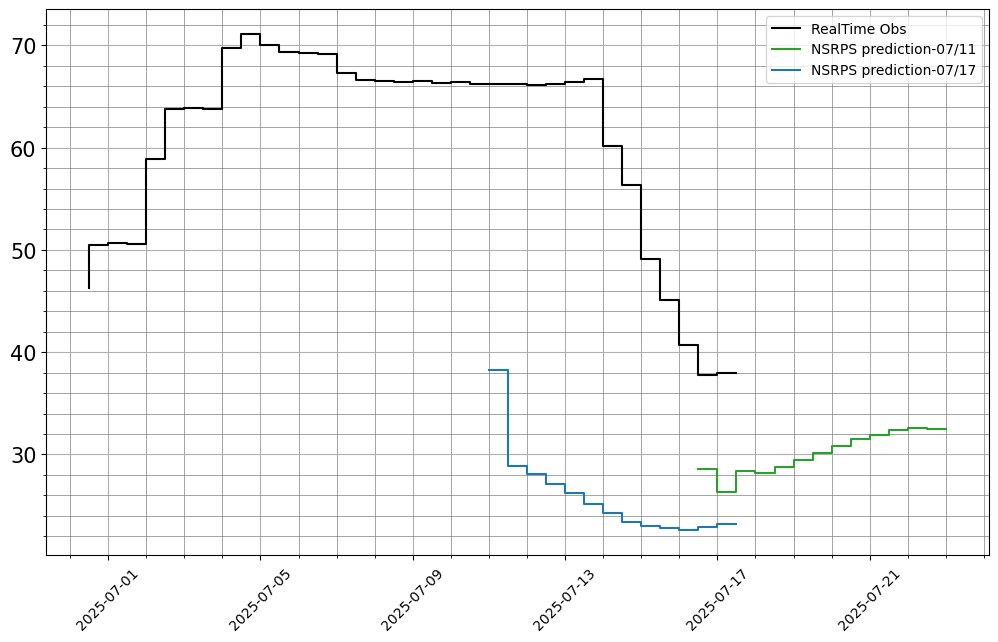

In [27]:
visuals.plot(merged_df = combined["2025-06-30 12:00:00+00:00":].iloc[:, [0,1,2]], step = True, grid = True, minor_grid= True,
             legend = ["RealTime Obs", "NSRPS prediction-07/11", "NSRPS prediction-07/17"],
            linestyles = ("k-", "(0.173, 0.628, 0.173)-", "(0.122, 0.467, 0.706)-"))

<Axes: >

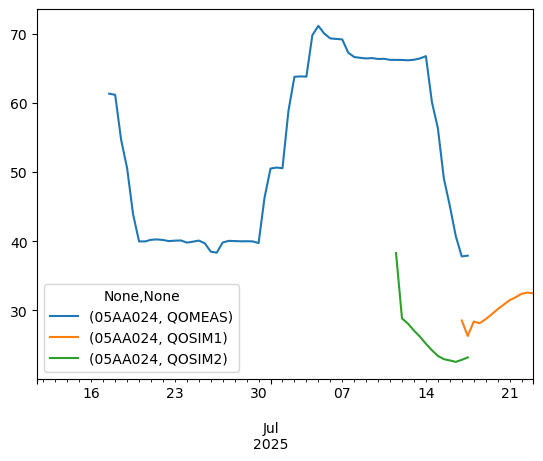

In [12]:
combined.iloc[:, 0:3].plot()